## KGB Model LN Auto V2 - Non Derog

In [2]:
!pip install xgboost


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import json
import logging
import xgboost as xgb
import ast
import itertools
import scipy.stats as ss
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2
import os
import sys

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', None)

In [4]:
sys.path.append('/root/Unified_LN_V2/')
from Utilities import *

In [5]:
Train = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_Train_Funded_Data_250324.csv')
Test = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_Test_Funded_Data_250324.csv')
Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_Oot_Funded_Data_250324.csv')
TTD= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_TTD_Data_250324.csv')
# TTD_Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/1_LN_Auto_V2_OOT_Data_220324.csv')

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 347), (62938, 347), (37121, 345), (700580, 345))

In [6]:
req_cols= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'derogtimenewest', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'derogcount', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'criminalnonfelonytimenewest', 'lienjudgmentdollartotal', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'evictiontimenewest', 'bankruptcycount', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'criminalnonfelonycount', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentcorrectional', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilecorrectional', 'addronfilehighrisk', 'addrpreviouscorrectional', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetownership', 'assetpersonal', 'assetpersonalcount', 'assetprop', 'assetpropnewestmortgagetype', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'bankruptcychapter', 'bankruptcycount24month', 'bankruptcydismissed24month', 'bankruptcystatus', 'bankruptcytimenewest', 'businessassociation', 'criminalfelonycount', 'criminalfelonycount12month', 'criminalfelonytimenewest', 'criminalnonfelonycount12month', 'derogcount12month', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'evictioncount', 'evictioncount12month', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'lienjudgmentcount', 'lienjudgmentcount12month', 'lienjudgmentcourtcount', 'lienjudgmentforeclosurecount', 'lienjudgmentothercount', 'lienjudgmentsmallclaimscount', 'lienjudgmenttaxcount', 'lienjudgmenttimenewest', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols)

130

In [7]:
all_cols= ['unique_id', 'client', 'app_date', 'approve_flag', 'funded_flag', 'fico_pb', 'fico_cb', 'bad_flag', 'product', 'auto_score', 'bankcard_score', 'Race', 'Gender', 'age_cuts'] + req_cols
len(all_cols)

144

In [8]:
print({'Length': Train['funded_flag'].sum(), 'Bads': Train['bad_flag'].sum()})
print({'Length': Test['funded_flag'].sum(), 'Bads': Test['bad_flag'].sum()})
print({'Length': Oot['funded_flag'].sum(), 'Bads': Oot['bad_flag'].sum()})

{'Length': 146855.0, 'Bads': 2227.0}
{'Length': 62938.0, 'Bads': 959.0}
{'Length': 37121.0, 'Bads': 545.0}


In [9]:
Train.shape, Test.shape, Oot.shape

((146855, 347), (62938, 347), (37121, 345))

In [10]:
print(TTD.shape)
TTD= TTD[TTD['client']!= 'CPM'].reset_index(drop= True)
print(TTD.shape)
# TTD_Oot= TTD_Oot[TTD_Oot['client']!= 'CPM'].reset_index(drop= True)

(700580, 345)
(685215, 345)


In [11]:
Train= Train[all_cols + ['weight']]
Test= Test[all_cols + ['weight']]
Oot= Oot[all_cols]
TTD= TTD[all_cols]
# TTD_Oot= TTD_Oot[all_cols]

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 145), (62938, 145), (37121, 144), (685215, 144))

In [12]:
Train.rename(columns= {'weight': 'wt2'}, inplace= True)
Test.rename(columns= {'weight': 'wt2'}, inplace= True)

In [13]:
Train['bad_flag'].mean(), Test['bad_flag'].mean(), Oot['bad_flag'].mean()

(0.015164618160770828, 0.015237217579204931, 0.01468171654858436)

In [14]:
TTD['funded_flag'].sum(), len(Train), len(Test)

(200148.0, 146855, 62938)

In [15]:
all_funded= pd.concat([Train, Test]).reset_index(drop= True)
all_funded.shape

(209793, 145)

In [16]:
all_funded['client'].value_counts(dropna= False)

client
Tower       42966
Arkansas    39869
GESA        28069
Guardian    27406
Numerica    25791
SECU        18365
Bethpage    11837
CPM          9645
HFCU         2895
Hawaii       2077
NCU           873
Name: count, dtype: int64

In [17]:
all_funded['bad_flag'].mean()

0.015186398020906322

In [18]:
def get_segment(d):
    if (d['derogcount']> 0):
        return 'Derog'
    elif ((d['derogcount']== 0) and (d['assetprop']> 0)):
        return 'Property Owner'
    elif ((d['derogcount']== 0) and (d['assetprop']== 0)):
        return 'Non Property Owner'
    else:
        return 'Missing'

In [19]:
%%time
all_funded['segment']= all_funded.apply(lambda x: get_segment(x), axis= 1)
all_funded['segment'].value_counts(dropna= False)

CPU times: user 3.14 s, sys: 226 µs, total: 3.14 s
Wall time: 3.69 s


segment
Property Owner        117191
Non Property Owner     69928
Derog                  22674
Name: count, dtype: int64

In [20]:
all_funded.groupby('segment')[['derogcount', 'assetprop']].agg(['min', 'max'])

derogcount       assetprop     
                          min   max       min  max
segment                                           
Derog                     1.0  52.0       0.0  1.0
Non Property Owner        0.0   0.0       0.0  0.0
Property Owner            0.0   0.0       1.0  1.0

In [21]:
%%time
TTD['segment']= TTD.apply(lambda x: get_segment(x), axis= 1)
TTD['segment'].value_counts(dropna= False)

CPU times: user 9.8 s, sys: 1.6 s, total: 11.4 s
Wall time: 12 s


segment
Property Owner        303020
Non Property Owner    275182
Derog                 107013
Name: count, dtype: int64

In [22]:
TTD.groupby('segment')[['derogcount', 'assetprop']].agg(['min', 'max'])

derogcount       assetprop     
                          min   max       min  max
segment                                           
Derog                     1.0  52.0       0.0  1.0
Non Property Owner        0.0   0.0       0.0  0.0
Property Owner            0.0   0.0       1.0  1.0

In [23]:
%%time
Oot['segment']= Oot.apply(lambda x: get_segment(x), axis= 1)
Oot['segment'].value_counts(dropna= False)

CPU times: user 520 ms, sys: 64 µs, total: 520 ms
Wall time: 518 ms


segment
Property Owner        20750
Non Property Owner    12460
Derog                  3911
Name: count, dtype: int64

In [24]:
Oot.groupby('segment')[['derogcount', 'assetprop']].agg(['min', 'max'])

derogcount       assetprop     
                          min   max       min  max
segment                                           
Derog                     1.0  51.0       0.0  1.0
Non Property Owner        0.0   0.0       0.0  0.0
Property Owner            0.0   0.0       1.0  1.0

In [25]:
all_funded= all_funded[all_funded['segment']!= 'Derog'].reset_index(drop= True)
TTD= TTD[TTD['segment']!= 'Derog'].reset_index(drop= True)
Oot= Oot[Oot['segment']!= 'Derog'].reset_index(drop= True)
print(all_funded.shape, all_funded['bad_flag'].mean()*100, all_funded['segment'].unique())
print(TTD.shape, TTD['segment'].unique())
print(Oot.shape, Oot['segment'].unique())
all_funded['client'].value_counts(dropna= False)

(187119, 146) 1.3606314698133273 ['Property Owner' 'Non Property Owner']
(578202, 145) ['Property Owner' 'Non Property Owner']
(33210, 145) ['Property Owner' 'Non Property Owner']


client
Tower       40584
Arkansas    36044
GESA        24558
Guardian    23137
Numerica    21539
SECU        16241
Bethpage    11048
CPM          8712
HFCU         2499
Hawaii       1992
NCU           765
Name: count, dtype: int64

In [26]:
TTD['funded_flag'].sum(), len(Train), len(Test)

(178407.0, 146855, 62938)

In [27]:
all_funded['bad_flag'].mean()

0.013606314698133273

In [28]:
req_cols_orig= req_cols.copy()
len(req_cols_orig), len(req_cols)

(130, 130)

In [29]:
### Checking for the singular value variable 
var_singular= []
for v in req_cols:
    if all_funded[v].nunique()== 1:
        print(v, all_funded[v].unique())
        var_singular.append(v)
    else:
        continue
        
var_singular, len(var_singular)

derogtimenewest [-1.]
derogcount [0.]
criminalnonfelonytimenewest [-1.]
lienjudgmentdollartotal [0.]
evictiontimenewest [-1.]
bankruptcycount [0.]
criminalnonfelonycount [0.]
addrcurrentcorrectional [0.]
addrpreviouscorrectional [0.]
bankruptcychapter [0.]
bankruptcycount24month [0.]
bankruptcydismissed24month [0.]
bankruptcystatus [0.]
bankruptcytimenewest [-1.]
criminalfelonycount [0.]
criminalfelonycount12month [0.]
criminalfelonytimenewest [-1.]
criminalnonfelonycount12month [0.]
derogcount12month [0.]
evictioncount [0.]
evictioncount12month [0.]
lienjudgmentcount [0.]
lienjudgmentcount12month [0.]
lienjudgmentcourtcount [0.]
lienjudgmentforeclosurecount [0.]
lienjudgmentothercount [0.]
lienjudgmentsmallclaimscount [0.]
lienjudgmenttaxcount [0.]
lienjudgmenttimenewest [-1.]


(['derogtimenewest',
  'derogcount',
  'criminalnonfelonytimenewest',
  'lienjudgmentdollartotal',
  'evictiontimenewest',
  'bankruptcycount',
  'criminalnonfelonycount',
  'addrcurrentcorrectional',
  'addrpreviouscorrectional',
  'bankruptcychapter',
  'bankruptcycount24month',
  'bankruptcydismissed24month',
  'bankruptcystatus',
  'bankruptcytimenewest',
  'criminalfelonycount',
  'criminalfelonycount12month',
  'criminalfelonytimenewest',
  'criminalnonfelonycount12month',
  'derogcount12month',
  'evictioncount',
  'evictioncount12month',
  'lienjudgmentcount',
  'lienjudgmentcount12month',
  'lienjudgmentcourtcount',
  'lienjudgmentforeclosurecount',
  'lienjudgmentothercount',
  'lienjudgmentsmallclaimscount',
  'lienjudgmenttaxcount',
  'lienjudgmenttimenewest'],
 29)

In [30]:
req_cols= [col for col in req_cols_orig if col not in var_singular]
print(req_cols)
print(len(req_cols))

['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrent

In [31]:
# !mkdir /root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Derog_Model
# !mkdir /root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Derog_Model/Mono_Data
# !mkdir /root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Derog_Model/Data

In [32]:
path_mono= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Derog_Model/Mono_Data/'
path_data= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Derog_Model/Data/'
path_model= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Derog_Model/'

In [33]:
del Train, Test

In [50]:
## Splitting the data into train and test
from sklearn.model_selection import train_test_split
Train, Test= train_test_split(all_funded, test_size= 0.3, random_state= 2021)
print(Train.shape, Test.shape)
print(Train['bad_flag'].mean(), Test['bad_flag'].mean())
print(sum(Train['bad_flag']*Train['wt2'])/Train['wt2'].sum(), sum(Test['bad_flag']*Test['wt2'])/Test['wt2'].sum())

(130983, 146) (56136, 146)
0.013620088103036271 0.0135741769987174
0.018348766251732526 0.018970141689058136


In [51]:
pref= 'Non_Derog'
# Train.to_csv(f'{path_data}{pref}_Auto_train_raw_data_290324.csv', index= False)
# Test.to_csv(f'{path_data}{pref}_Auto_test_raw_data_290324.csv', index= False)
# Oot.to_csv(f'{path_data}{pref}_Auto_oot_raw_data_290324.csv', index= False)
# TTD.to_csv(f'{path_data}{pref}_Auto_ttd_raw_data_290324.csv', index= False)

In [52]:
all_funded['fico_pb'].isnull().sum()

248

In [53]:
all_funded.groupby(['client']).agg(
    funded= ('funded_flag', 'sum'),
    bad= ('bad_flag', 'sum'),
    bad_rate= ('bad_flag', 'mean')
)

,funded,bad,bad_rate
client,,,
Arkansas,36044.0,215.0,0.005965
Bethpage,11048.0,71.0,0.006427
CPM,8712.0,117.0,0.013430
GESA,24558.0,439.0,0.017876
Guardian,23137.0,308.0,0.013312
HFCU,2499.0,43.0,0.017207
Hawaii,1992.0,4.0,0.002008
NCU,765.0,10.0,0.013072
Numerica,21539.0,295.0,0.013696


In [54]:
del all_funded

In [55]:
Train['bad_flag'].mean(), Test['bad_flag'].mean(), Oot['bad_flag'].mean()

(0.013620088103036271, 0.0135741769987174, 0.012947907256850346)

In [56]:
### Convert the Variable into categorical
var_to_cat= '''businesstitleleadership
proflictypecategory
addrcurrentdeedmailing
addrcurrentphoneservice
addrcurrentsubjectowned
addrinputdeedmailing
addrinputphoneservice
addrinputproblems
addrinputsubjectowned
addrlastmoveecontrajectory
addronfilecollege
addronfilecorrectional
addronfilehighrisk
addrprevioussubjectowned
alertregulatorycondition
assetownership
assetpersonal
assetprop
assetpropnewestmortgagetype
bankruptcychapter
bankruptcystatus
businessassociation
educationattendance
educationevidence
educationinstitutionrating
educationprogramattended
inquiryauto12month
inquirybanking12month
inquirycollections12month
inquirynonshortterm12month
inquiryshortterm12month
inquirytelcom12month
shorttermloanrequest
shorttermloanrequest12month
shorttermloanrequest24month
subjectnewestrecord12month
sourcevoterregistration'''.splitlines()
len(var_to_cat)

37

In [57]:
for var in var_to_cat:
    Train[var]= [f"[{i}]" if i!= '[-1]' else i for i in Train[var].astype(int).astype(str)]
    Test[var]= [f"[{i}]" if i!= '[-1]' else i for i in Test[var].astype(int).astype(str)]
    Oot[var]= [f"[{i}]" if i!= '[-1]' else i for i in Oot[var].astype(int).astype(str)]
    TTD[var]= [f"[{i}]" if i!= '[-1]' else i for i in TTD[var].astype(int).astype(str)]

In [58]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))
print(Oot['bankruptcystatus'].value_counts(dropna= False))
print(TTD['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]    130983
Name: count, dtype: int64
bankruptcystatus
[0]    56136
Name: count, dtype: int64
bankruptcystatus
[0]    33210
Name: count, dtype: int64
bankruptcystatus
[0]    578202
Name: count, dtype: int64


#### Monotonic Binning

In [59]:
import pickle

configFile= Train[req_cols].dtypes.reset_index()
configFile.columns= ['Feature_Name', 'dtypes']
configFile['Special_values']= '[[-1]]'
# configFile['Monotonicity']= 'Y'
configFile['Monotonicity']= np.where(~configFile['Feature_Name'].isin(var_to_cat), 'Y', 'N')
del configFile['dtypes']
configFile.head()

,Feature_Name,Special_values,Monotonicity
0,assetpropevercount,[[-1]],Y
1,sourcenonderogcount06month,[[-1]],Y
2,addronfilecount,[[-1]],Y
3,addrinputcountyratio,[[-1]],Y
4,assetpropnewestsaleprice,[[-1]],Y


In [60]:
with open(f'{path_mono}configFile.pickle', 'wb') as f:
    pickle.dump(configFile, f)

In [61]:
dep_var = "bad_flag"
weight_column = 'wt2'
min_bin_size = 0.1
index_col=[]

In [62]:
# Get feature meta
# special_values = pd.read_csv(config_file)
import ast
special_values= configFile.copy()
# Converting the string entered in CSV to list of lists
special_values['Special_values'] = special_values['Special_values'].apply(lambda x: ast.literal_eval(str(x)))
# Generate feature meta
feature_meta = GenMeta(Train, index_col, sample_size=50000)
feature_meta = pd.merge(feature_meta, special_values, on="Feature_Name", how="left").replace(np.nan, '')
feature_meta.index = feature_meta['Feature_Name']
feature_meta.head()

,Feature_Name,Datatype,Special_values,Monotonicity
Feature_Name,,,,
unique_id,unique_id,string,,
client,client,string,,
app_date,app_date,string,,
approve_flag,approve_flag,float,,
funded_flag,funded_flag,float,,


In [63]:
with open(f'{path_mono}feature_meta.pickle', 'wb') as f:
    pickle.dump(feature_meta, f)

In [64]:
# Get numeric and embedding dataframe
embed_df, numeric_df = embedding_numeric_df(feature_meta, dep_var, index_col)

# Removing weight_column and columns that are not mentioned in the config file
embed_df.loc[np.invert(embed_df['Feature_Name'].isin(special_values['Feature_Name'].tolist())), 'Use_Feature'] = 'N'
numeric_df.loc[
        np.invert(numeric_df['Feature_Name'].isin(special_values['Feature_Name'].tolist())), 'Use_Feature'] = 'N'

if weight_column is not None:
    numeric_df.loc[numeric_df['Feature_Name'] == weight_column, 'Use_Feature'] = 'N'
    
display(numeric_df.head())
display(embed_df.head())

,Feature_Name,Use_Feature,Bucket_Size
Feature_Name,,,
approve_flag,approve_flag,N,10
funded_flag,funded_flag,N,10
fico_pb,fico_pb,N,10
fico_cb,fico_cb,N,10
bad_flag,bad_flag,N,10


,Feature_Name,Use_Feature,Num_Hash_Buckets,Num_Embedding_Columns
Feature_Name,,,,
unique_id,unique_id,N,10,2
client,client,N,10,2
app_date,app_date,N,10,2
product,product,N,10,2
Race,Race,N,10,2


In [65]:
with open(f'{path_mono}embed_df.pickle', 'wb') as f:
    pickle.dump(embed_df, f)

with open(f'{path_mono}numeric_df.pickle', 'wb') as f:
    pickle.dump(numeric_df, f)

In [66]:
# Get feature boundaries
feature_boundaries, numeric_df = get_boundaries_cart(filename=Train, sample_size=5000, shuffle_ind=False,
                                                         batch_size=100000,
                                                         shuffle_size=50000, feature_meta=feature_meta,
                                                         numeric_df=numeric_df,
                                                         dep_var=dep_var,
                                                         weight_column=weight_column, min_bin_size=float(min_bin_size))

assetpropevercount
0.0
assetpropevercount : [-inf, 1.0, 2.0, 3.0, inf]
sourcenonderogcount06month
0.0
sourcenonderogcount06month : [-inf, 2.0, inf]
addronfilecount
0.0
addronfilecount : [-inf, 2.0, 3.0, inf]
addrinputcountyratio
0.0
addrinputcountyratio : [-inf, 0.170000002, 0.649999976, 0.889999986, 1.05999994, 1.33000004, inf]
assetpropnewestsaleprice
1.0
assetpropnewestsaleprice : [-inf, 102730.0, 192000.0, 393925.0, inf]
addrcurrenttaxvalue
0.0
addrcurrenttaxvalue : [-inf, 507.0, 257167.0, inf]
addrinputavmvalue
2367.0
addrinputavmvalue : [-inf, 98615.0, 140166.0, 225295.0, 285000.0, 356957.0, 472219.0, inf]
addrinputavmvalue60month
3752.0
addrinputavmvalue60month : [-inf, 86689.0, 124910.0, 183866.0, 245005.0, 378375.0, inf]
addrinputlastsaleprice
1.0
addrinputlastsaleprice : [-inf, 68500.0, 130000.0, 242000.0, 302500.0, 395000.0, inf]
addrinputtaxmarketvalue
0.0
addrinputtaxmarketvalue : [-inf, 22000.0, 162200.0, 312800.0, inf]
sourcecredheadertimeoldest
1.0
sourcecredheadertimeo

In [67]:
with open(f'{path_mono}feature_boundaries.pickle', 'wb') as f:
    pickle.dump(feature_boundaries, f)

In [68]:
# Get train bivar tables + get binned train dataframe
bivar_tables, rep_values, binned_df = get_bivar_tables(filename=Train, predicted=None,
                                                           feature_meta=feature_meta,
                                                           feature_boundaries=feature_boundaries,
                                                           num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           dep_var=dep_var, weight_column=None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
addrcurrentlastsalesprice
addrinputtimenewest
addrcurrentt

In [69]:
# Get train bivar tables + get binned train dataframe
bivar_tables_holdout, rep_values_holdout, binned_df_holdout = get_bivar_tables(filename=Test, predicted=None,
                                                           feature_meta=feature_meta,
                                                           feature_boundaries=feature_boundaries,
                                                           num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           dep_var=dep_var, weight_column=None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
addrcurrentlastsalesprice
addrinputtimenewest
addrcurrentt

In [70]:
# Get train bivar tables + get binned train dataframe
binned_df_oot = get_bivar_tables_test(filename=Oot, predicted=None,
                                   feature_meta=feature_meta,
                                   feature_boundaries=feature_boundaries,
                                   num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   dep_var=None, weight_column= None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
addrcurrentlastsalesprice
addrinputtimenewest
addrcurrentt

In [71]:
# Get train bivar tables + get binned train dataframe
binned_df_ttd = get_bivar_tables_test(filename=TTD, predicted=None,
                                   feature_meta=feature_meta,
                                   feature_boundaries=feature_boundaries,
                                   num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   dep_var=None, weight_column= None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
addrcurrentlastsalesprice
addrinputtimenewest
addrcurrentt

In [72]:
print(binned_df.shape, Train.shape)
print(binned_df_holdout.shape, Test.shape)
print(binned_df_oot.shape, Oot.shape)
print(binned_df_ttd.shape, TTD.shape)

(130983, 146) (130983, 146)
(56136, 146) (56136, 146)
(33210, 145) (33210, 145)
(578202, 145) (578202, 145)


In [73]:
binned_df.to_csv(f'{path_mono}{pref}_1_Auto_Train_Binned_Data_290324.csv', index= False)
binned_df_holdout.to_csv(f'{path_mono}{pref}_1_Auto_Test_Binned_Data_290324.csv', index= False)
binned_df_oot.to_csv(f'{path_mono}{pref}_1_Auto_Oot_Binned_Data_290324.csv', index= False)
binned_df_ttd.to_csv(f'{path_mono}{pref}_1_Auto_Ttd_Binned_Data_290324.csv', index= False)

In [74]:
del Train, Test, Oot, TTD, binned_df, binned_df_holdout, binned_df_oot, binned_df_ttd

#### Reading Data For Model Building

In [5]:
import gc
gc.collect()

0

In [6]:
pref= 'Non_Derog'
path_mono= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Derog_Model/Mono_Data/'
path_data= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Derog_Model/Data/'
path_model= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Derog_Model/'

In [7]:
Train = pd.read_csv(f'{path_mono}{pref}_1_Auto_Train_Binned_Data_290324.csv')
Test = pd.read_csv(f'{path_mono}{pref}_1_Auto_Test_Binned_Data_290324.csv')
Oot= pd.read_csv(f'{path_mono}{pref}_1_Auto_Oot_Binned_Data_290324.csv')
TTD= pd.read_csv(f'{path_mono}{pref}_1_Auto_Ttd_Binned_Data_290324.csv')
# TTD_Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/1_LN_Auto_V2_OOT_Data_220324.csv')

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((130983, 146), (56136, 146), (33210, 145), (578202, 145))

In [8]:
req_cols_orig= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'derogtimenewest', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'derogcount', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'criminalnonfelonytimenewest', 'lienjudgmentdollartotal', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'evictiontimenewest', 'bankruptcycount', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'criminalnonfelonycount', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentcorrectional', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilecorrectional', 'addronfilehighrisk', 'addrpreviouscorrectional', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetownership', 'assetpersonal', 'assetpersonalcount', 'assetprop', 'assetpropnewestmortgagetype', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'bankruptcychapter', 'bankruptcycount24month', 'bankruptcydismissed24month', 'bankruptcystatus', 'bankruptcytimenewest', 'businessassociation', 'criminalfelonycount', 'criminalfelonycount12month', 'criminalfelonytimenewest', 'criminalnonfelonycount12month', 'derogcount12month', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'evictioncount', 'evictioncount12month', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'lienjudgmentcount', 'lienjudgmentcount12month', 'lienjudgmentcourtcount', 'lienjudgmentforeclosurecount', 'lienjudgmentothercount', 'lienjudgmentsmallclaimscount', 'lienjudgmenttaxcount', 'lienjudgmenttimenewest', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols_orig)

130

In [9]:
# print(req_cols)

In [10]:
req_cols= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilecorrectional', 'addronfilehighrisk', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetownership', 'assetpersonal', 'assetpersonalcount', 'assetprop', 'assetpropnewestmortgagetype', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'businessassociation', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols)

101

In [11]:
all_cols= ['unique_id', 'client', 'app_date', 'approve_flag', 'funded_flag', 'fico_pb', 'fico_cb', 'bad_flag', 'product', 'auto_score', 'bankcard_score', 'Race', 'Gender', 'age_cuts'] + req_cols_orig
len(all_cols)

144

In [12]:
Train[all_cols].head(2)

,unique_id,client,app_date,approve_flag,funded_flag,fico_pb,fico_cb,bad_flag,product,auto_score,bankcard_score,Race,Gender,age_cuts,assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
0,197665,Arkansas,2021-08-23,1.0,1.0,804.0,0.0,0.0,Auto,786.0,869.0,missing,M,Age below 62,"[1.0, 2.0)","[-inf, 2.0)","[3.0, inf)","[1.33, inf)",[-1],"[507.0, 257167.0)","[356957.0, 472219.0)","[378375.0, inf)","[302500.0, 395000.0)","[312800.0, inf)","[265.0, 368.0)","[-inf, 0.436)","[16660.0, 376600.0)","[388174.0, inf)","[-inf, 31.0)","[137.0, inf)","[-inf, 13.0)","[309660.0, inf)","[-inf, 14.0)","[1.49, inf)","[2.0, inf)","[1.0, 2.0)","[2.0, inf)","[3.0, 4.0)","[500.0, 257900.0)","[-inf, 1.0)","[13.0, 30.0)","[1.39, inf)",-1.0,"[1.0, inf)","[10.0, 44.0)",[-1],"[1.4, inf)",[2],"[7.0, 16.0)","[-inf, 1.33)","[1.43, inf)",0.0,"[-inf, 0.0456)","[-inf, 1.37)","[1.33, inf)",[-1],"[266.0, 371.0)","[-inf, 4.696)",[-1],-1.0,0.0,"[243000.0, 395000.0)","[-inf, 2.53)",-1.0,0.0,"[9.0, 44.0)","[-inf, 12.0)",[-1],0.0,"[-inf, 2.0)","[-inf, 0.0401)","[-inf, 0.085)","[1.0, inf)","[1.0, 

In [13]:
print({'Length': Train['funded_flag'].sum(), 'Bads': Train['bad_flag'].sum(), 'Bad_Rate': Train['bad_flag'].mean()*100})
print({'Length': Test['funded_flag'].sum(), 'Bads': Test['bad_flag'].sum(), 'Bad_Rate': Test['bad_flag'].mean()*100})
print({'Length': Oot['funded_flag'].sum(), 'Bads': Oot['bad_flag'].sum(), 'Bad_Rate': Oot['bad_flag'].mean()*100})
print(Train['segment'].unique(), Test['segment'].unique(), Oot['segment'].unique(), TTD['segment'].unique())

{'Length': 130983.0, 'Bads': 1784.0, 'Bad_Rate': 1.3620088103036272}
{'Length': 56136.0, 'Bads': 762.0, 'Bad_Rate': 1.35741769987174}
{'Length': 33210.0, 'Bads': 430.0, 'Bad_Rate': 1.2947907256850346}
['Property Owner' 'Non Property Owner'] ['Non Property Owner' 'Property Owner'] ['Property Owner' 'Non Property Owner'] ['Property Owner' 'Non Property Owner']


In [14]:
Train.shape, Test.shape, Oot.shape

((130983, 146), (56136, 146), (33210, 145))

In [15]:
Train['wt2'].describe([0.9, 0.95, 0.99])

count    130983.000000
mean          1.589875
std           0.457885
min           1.060974
50%           1.445358
90%           2.153226
95%           2.483169
99%           3.224371
max          11.046260
Name: wt2, dtype: float64

In [16]:
Train.groupby('client')['wt2'].agg(['count', 'min', 'mean', 'max'])

,count,min,mean,max
client,,,,
Arkansas,25123,1.095290,1.541546,7.325095
Bethpage,7729,1.060974,1.418728,4.755939
CPM,6143,1.105308,1.556270,4.911142
GESA,17211,1.087837,1.719485,7.651940
Guardian,16232,1.101219,1.785375,11.046260
HFCU,1742,1.117645,1.567811,4.857668
Hawaii,1419,1.084118,1.758867,4.097788
NCU,535,1.148353,1.712435,4.476998
Numerica,15059,1.096292,1.652791,6.790337


In [17]:
Train= Train[all_cols + ['wt2']]
Test= Test[all_cols + ['wt2']]
Oot= Oot[all_cols]
TTD= TTD[all_cols]
# TTD_Oot= TTD_Oot[all_cols]

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((130983, 145), (56136, 145), (33210, 144), (578202, 144))

In [18]:
### Convert the Variable into categorical
var_to_cat= '''businesstitleleadership
proflictypecategory
addrcurrentdeedmailing
addrcurrentphoneservice
addrcurrentsubjectowned
addrinputdeedmailing
addrinputphoneservice
addrinputproblems
addrinputsubjectowned
addrlastmoveecontrajectory
addronfilecollege
addronfilecorrectional
addronfilehighrisk
addrprevioussubjectowned
alertregulatorycondition
assetownership
assetpersonal
assetprop
assetpropnewestmortgagetype
bankruptcychapter
bankruptcystatus
businessassociation
educationattendance
educationevidence
educationinstitutionrating
educationprogramattended
inquiryauto12month
inquirybanking12month
inquirycollections12month
inquirynonshortterm12month
inquiryshortterm12month
inquirytelcom12month
shorttermloanrequest
shorttermloanrequest12month
shorttermloanrequest24month
subjectnewestrecord12month
sourcevoterregistration'''.splitlines()
len(var_to_cat)

37

In [19]:
var_to_cat= list(set(var_to_cat))
len(var_to_cat)

37

In [20]:
# for var in var_to_cat:
#     Train[var]= [f"[{i}]" if i!= '[-1]' else i for i in Train[var].astype(int).astype(str)]
#     Test[var]= [f"[{i}]" if i!= '[-1]' else i for i in Test[var].astype(int).astype(str)]
#     Oot[var]= [f"[{i}]" if i!= '[-1]' else i for i in Oot[var].astype(int).astype(str)]
#     TTD[var]= [f"[{i}]" if i!= '[-1]' else i for i in TTD[var].astype(int).astype(str)]

In [21]:
print(Train['assetpersonal'].value_counts(dropna= False))
print(Test['assetpersonal'].value_counts(dropna= False))
print(Oot['assetpersonal'].value_counts(dropna= False))
print(TTD['assetpersonal'].value_counts(dropna= False))

assetpersonal
[0]    119318
[1]     11665
Name: count, dtype: int64
assetpersonal
[0]    51037
[1]     5099
Name: count, dtype: int64
assetpersonal
[0]    30243
[1]     2967
Name: count, dtype: int64
assetpersonal
[0]    538721
[1]     39481
Name: count, dtype: int64


In [22]:
Train[req_cols].isnull().sum()

assetpropevercount                 0
sourcenonderogcount06month         0
addronfilecount                    0
addrinputcountyratio               0
assetpropnewestsaleprice           0
addrcurrenttaxvalue                0
addrinputavmvalue                  0
addrinputavmvalue60month           0
addrinputlastsaleprice             0
addrinputtaxmarketvalue            0
sourcecredheadertimeoldest         0
addrinputphonecount                0
assetpropcurrenttaxtotal           0
addrcurrentavmvalue                0
assetproppurchasetimeoldest        0
addrpreviouslengthofres            0
addrinputlengthofres               0
addrcurrenttaxmarketvalue          0
addrprevioustimenewest             0
addrcurrenttractratio              0
sourcenonderogcount12month         0
assetpropcurrentcount              0
addrinputsubjectcount              0
sourcenonderogcount                0
addrinputtaxvalue                  0
assetpropeversoldcount             0
businessassociationtimeoldest      0
a

In [23]:
path_to_save= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Derog_Model/'

In [24]:
Train['funded_flag'].sum(), Train.shape, Train['bad_flag'].sum(), Train['bad_flag'].mean()

(130983.0, (130983, 145), 1784.0, 0.013620088103036271)

In [25]:
Test['funded_flag'].sum(), Test.shape, Test['bad_flag'].sum(), Test['bad_flag'].mean()

(56136.0, (56136, 145), 762.0, 0.0135741769987174)

In [26]:
def Bucket_Order(data):
    data['lower_bound'] = data['Bucket'].str.replace('[','').str.replace(']','').str.replace('(','').str.replace(')','').str.split(',').str[0]
    data['lower_bound'] = data['lower_bound'].apply(lambda x: -np.inf if x == '-inf' else np.inf if x == 'inf' else float(x))
    data = data.sort_values('lower_bound')
    a = data.loc[data['lower_bound']==-1]
    b = data.loc[data['lower_bound']!=-1]
    b['Is_Trend']= 'Yes' if (
            (b['Train_BadRate'].is_monotonic_decreasing and b['Test_BadRate'].is_monotonic_decreasing) or
            (b['Train_BadRate'].is_monotonic_increasing and b['Test_BadRate'].is_monotonic_increasing)
        ) else 'No'
    data = pd.concat(objs=[a,b])
    data = data.drop(columns=['lower_bound'])
    return data

In [97]:
df_bv= pd.DataFrame()

for col in req_cols:
    print(col)
    ### Train
    temp_tr= Train.groupby(col).agg(
        bad_count_tr= ('bad_flag', 'sum'),
        bad_rate_tr= ('bad_flag', 'mean'),
                                # p1_bad_rate_tr= ('p1', 'mean'),
                                   volume_tr= ('unique_id', 'count')).reset_index()
    temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_Count']#'Train_P1', 
    temp_tr.insert(0, 'variable', col)
    
    # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
    # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
    # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
    # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
    ### Test
    temp_te= Test.groupby(col).agg(
        bad_count_te= ('bad_flag', 'sum'),
        bad_rate_te= ('bad_flag', 'mean'),
                                # p1_bad_rate_te= ('p1', 'mean'),
                                  volume_te= ('unique_id', 'count')).reset_index()
    temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_Count']#'Test_P1', 
    #temp_te['variable']= col
    
    # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
    # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
    # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
    # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
    ### Concatenating
    temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
    # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
    temp= Bucket_Order(temp)
    # display(temp)
    
    df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
    del temp, temp_tr, temp_te

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
businesstitleleadership
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
proflictypecategory
addrcurrentlas

In [98]:
pd.options.display.max_rows= 1000
df_bv.head(10)

,variable,Bucket,Train_BadCount,Train_BadRate,Train_Count,Test_BadCount,Test_BadRate,Test_Count,Is_Trend
0,assetpropevercount,"[-inf, 1.0)",1223.0,0.027492,44485,545.0,0.028512,19115.0,Yes
1,assetpropevercount,"[1.0, 2.0)",364.0,0.007798,46681,146.0,0.007289,20031.0,Yes
2,assetpropevercount,"[2.0, 3.0)",114.0,0.005476,20819,49.0,0.005437,9012.0,Yes
3,assetpropevercount,"[3.0, inf)",83.0,0.004369,18998,22.0,0.002758,7978.0,Yes
4,sourcenonderogcount06month,"[-inf, 2.0)",1409.0,0.019655,71687,632.0,0.020562,30737.0,Yes
5,sourcenonderogcount06month,"[2.0, inf)",375.0,0.006324,59296,130.0,0.005118,25399.0,Yes
6,addronfilecount,"[-inf, 2.0)",384.0,0.021579,17795,178.0,0.023648,7527.0,Yes
7,addronfilecount,"[2.0, 3.0)",307.0,0.015353,19996,135.0,0.015551,8681.0,Yes
8,addronfilecount,"[3.0, inf)",1093.0,0.011728,93192,449.0,0.011245,39928.0,Yes
9,addrinputcountyratio,[-1],0.0,0.000000,1,NaN,NaN,NaN,NaN


In [99]:
var_trend_break= list(df_bv[(df_bv['Is_Trend']== 'No') & (~(df_bv['variable'].isin(var_to_cat)))]['variable'].unique())
var_trend_break, len(var_trend_break)

(['assetpropnewestsaleprice',
  'addrinputavmvalue',
  'addrinputlastsaleprice',
  'sourcecredheadertimeoldest',
  'addrcurrentavmvalue',
  'addrinputlengthofres',
  'addrcurrenttractratio',
  'addrinputsubjectcount',
  'businessassociationtimeoldest',
  'addrcurrentlengthofres',
  'addrinputavmratio60monthprior',
  'assetpropsaletimeoldest',
  'subjectrecordtimeoldest',
  'addrcurrentlastsalesprice',
  'addrcurrenttimelastsale',
  'addrinputtimeoldest',
  'addrcurrentavmratio60monthprior',
  'addrcurrentavmvalue60month',
  'addrinputavmratio12monthprior',
  'assetproppurchasetimenewest',
  'assetpropsaletimenewest'],
 21)

In [27]:
var_trend_break= ['assetpropnewestsaleprice',
  'addrinputavmvalue',
  'addrinputlastsaleprice',
  'sourcecredheadertimeoldest',
  'addrcurrentavmvalue',
  'addrinputlengthofres',
  'addrcurrenttractratio',
  'addrinputsubjectcount',
  'businessassociationtimeoldest',
  'addrcurrentlengthofres',
  'addrinputavmratio60monthprior',
  'assetpropsaletimeoldest',
  'subjectrecordtimeoldest',
  'addrcurrentlastsalesprice',
  'addrcurrenttimelastsale',
  'addrinputtimeoldest',
  'addrcurrentavmratio60monthprior',
  'addrcurrentavmvalue60month',
  'addrinputavmratio12monthprior',
  'assetproppurchasetimenewest',
  'assetpropsaletimenewest']
len(var_trend_break), len(list(set(var_trend_break)))

(21, 21)

### Base Model Weighted Auto Without Segmentation Without FLA, LDA

In [28]:
!pip install hyperopt


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [29]:
import numpy as np
import pandas as pd
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
import h2o
from h2o.estimators import H2OXGBoostEstimator
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
import warnings
warnings.filterwarnings('ignore')

In [30]:
### Starting H2o Session
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpspfbv4d_
  JVM stdout: /tmp/tmpspfbv4d_/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpspfbv4d_/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_unknownUser_7j4vqj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.486 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [31]:
Train['unique_id']= Train['unique_id'].astype(str)
Test['unique_id']= Test['unique_id'].astype(str)
Oot['unique_id']= Oot['unique_id'].astype(str)
TTD['unique_id']= TTD['unique_id'].astype(str)

In [32]:
train_h2o = h2o.H2OFrame(Train)
test_h2o = h2o.H2OFrame(Test)
oot_h2o= h2o.H2OFrame(Oot)
ttd_h2o= h2o.H2OFrame(TTD)
print(Train.shape,train_h2o.shape,Test.shape,test_h2o.shape, oot_h2o.shape, ttd_h2o.shape)
bad_col = 'bad_flag'
Train[bad_col].mean(),Test[bad_col].mean()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
(130983, 145) (130983, 145) (56136, 145) (56136, 145) (33210, 144) (578202, 144)


(0.013620088103036271, 0.0135741769987174)

In [33]:
# for col in var_to_cat:
#     train_h2o[col] = train_h2o[col].asfactor()
#     test_h2o[col] = test_h2o[col].asfactor()
#     oot_h2o[col] = oot_h2o[col].asfactor()
#     ttd_h2o[col] = ttd_h2o[col].asfactor()

In [34]:
for k in Train['bankruptcychapter'].unique():
    print(k, train_h2o[train_h2o['bankruptcychapter']== k].shape)

[0] (130983, 145)


In [35]:
train_h2o[req_cols].head(rows= 2)

assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,addrcurrentlastsalesprice,addrinputtimenewest,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,businessassociation,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
"[1.0, 2.0)","[-inf, 2.0)","[3.0, inf)","[1.33, inf)",[-1],"[507.0, 257167.0)","[356957.0, 472219.0)","[378375.0, inf)","[302500.0, 395000.0)","[312800.0, inf)","[265.0, 368.0)","[-inf, 0.436)","[16660.0, 376600.0)","[388174.0, inf)","[-inf, 31.0)","[137.0, inf)","[-inf, 13.0)","[309660.0, inf)","[-inf, 14.0)","[1.49, inf)","[2.0, inf)","[1.0, 2.0)","[2.0, inf)","[3.0, 4.0)","[500.0, 257900.0)","[-inf, 1.0)","[13.0, 30.0)","[1.39, inf)","[1.0, inf)","[10.0, 44.0)",[-1],"[1.4, inf)",[2],"[7.0, 16.0)","[-inf, 1.33)","[1.43, inf)","[-inf, 0.0456)","[-inf, 1.37)","[1.33, inf)",[-1],"[266.0, 371.0)","[-inf, 4.696)",[-1],"[243000.0, 395000.0)","[-inf, 2.53)","[9.0, 44.0)","[-inf, 12.0)",[-1],"[-inf, 2.0)","[-inf, 0.0401)","[-inf, 0.085)","[1.0, inf)","[1.0, 2.0)","[-inf, 1.38)","[394710.0, inf)","[356696.0, inf)",[0],[0],[1],"[11.0, 32.0)","[-inf, 1.19)","[283229.0, 432744.0)",[0],[0],[0],[1],[11],[1],[0],[0],[1],"[138.0, 247.0)",[1],[1],[0],"[-inf, 0.2)",[1],[0],"[0.074, inf)","[-inf, 73.0)","[-inf, 0.144)",[-1],"[-inf, 0.0284)",[1],[0],[1],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],"[-inf, 2.568)",[1],[1],"[-inf, 1.63)"
"[-inf, 1.0)","[-inf, 2.0)","[-inf, 2.0)","[1.33, inf)",[-1],"[-inf, 507.0)","[225295.0, 285000.0)","[183866.0, 245005.0)",[-1],"[-inf, 22000.0)","[-inf, 65.0)","[0.436, inf)",[-1],"[224082.0, 263370.0)",[-1],[-1],"[31.0, 52.0)","[-inf, 22000.0)",[-1],"[1.04, 1.49)","[-inf, 2.0)","[-inf, 1.0)","[2.0, inf)","[-inf, 2.0)","[-inf, 500.0)","[-inf, 1.0)",[-1],"[1.03, 1.39)","[-inf, 1.0)",[-1],[-1],"[0.88, 1.01)",[-1],"[31.0, 53.0)","[-inf, 1.33)","[0.88, 1.01)","[-inf, 0.0456)","[-inf, 1.37)","[1.33, inf)",[-1],"[-inf,

In [36]:
# for var in var_to_cat:
#     print(var, ttd_h2o[var].unique())

### Baseline

In [37]:
# req_cols_orig= req_cols.copy()
len(req_cols_orig), len(req_cols)

(130, 101)

In [38]:
barsath_list_to_drop= '''addrinputavmvalue
addrinputphonecount
addrinputavmvalue12month
sourcevoterregistration
addrinputblockratio
addrinputcountyratio
educationinstitutionrating
addrcurrentavmvalue12month
addrinputavmvalue60month
addrlastmoveecontrajectory
addrcurrentavmvalue
businesstitleleadership
assetpropeversoldcount
addrprevioussubjectowned
addrinputtractratio
addrcurrentcountyratio
addrcurrentavmvalue60month
addrcurrentavmratio60monthprior
educationevidence
assetpersonal
proflictypecategory
addrprevioustimenewest'''.splitlines()
len(barsath_list_to_drop), len(list(set(barsath_list_to_drop)))

(22, 22)

In [39]:
unique_cols = ['unique_id', 'client']
wt_col = 'wt2'
folds = 10
# predictors = train_h2o.columns
req_cols = [var for var in req_cols if var not in barsath_list_to_drop + var_trend_break]
model_cols = unique_cols + [wt_col] + [bad_col] + req_cols
train_h2o[bad_col]= train_h2o[bad_col].asfactor()
len(req_cols)

62

In [40]:
train_h2o[req_cols].isna().sum()

0.0

### Run the Code

In [114]:
xgbm_auto_wt_segment_wt_lda_model = H2OXGBoostEstimator(
    ntrees=2000,    
    learn_rate=0.01,
    max_depth=2,    
    model_id=f"xgb_auto_wt_segment_with_lda_model_{pref}",
    distribution = "bernoulli",    
    seed=42,
    nfolds = folds)#,    ignored_columns = unique_cols)

In [115]:
%%time
xgbm_auto_wt_segment_wt_lda_model.train(y=bad_col, x= req_cols, training_frame=train_h2o, weights_column =wt_col)

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
CPU times: user 8.62 s, sys: 534 ms, total: 9.16 s
Wall time: 39min 19s


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgb_auto_wt_segment_with_lda_model_Non_Derog


Model Summary: 
    number_of_trees
--  -----------------
    2000

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.01740313159791229
RMSE: 0.13192092933993563
LogLoss: 0.07986392070625235
Mean Per-Class Error: 0.4110517887390036
AUC: 0.801162723069574
AUCPR: 0.08387532814401921
Gini: 0.6023254461391481

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07488914054502989
       0       1     Error    Rate
-----  ------  ----  -------  -----------------
0      198544  5880  0.0288   (5880.0/204424.0)
1      3031    789   0.7935   (3031.0/3820.0)
Total  201575  6669  0.0428   (8911.0/208244.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0748891    0.150534  117
max f2                       0.0451804    0.219912  183
max f0point5                 0.0962358    0.144033  84
max accuracy                 0.294718     0.981723  3
max precision                0.426157     1         0
max recall                   0.00124241   1         394
max specificity              0.426157     1         0
max absolute_mcc             0.0480164    0.144235  177
max min_per_class_accuracy   0.0221835    0.719956  268
max mean_per_class_accuracy  0.0188784    0.724924  283
max tns                      0.426157     204426    0
max fns                      0.426157     3814      0
max fps                      0.000533257  204426    399
max tps                      0.00124241   3821.07   394
max tnr                      0.426157     1         0
max fnr                      0.426157     0.998151  0
max fpr                      0.000533257  1         399
max tpr                      0.00124241   1         394

Gains/Lift Table: Avg response rate:  1.92 %, avg score:  2.51 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.011331                    0.111508           8.00382    8.00382            0.153712         0.164571    0.153712                    0.164571            0.0906913       0.0906913                  700.382   700.382            0.0809143
2        0.0231747                   0.0874339          6.06811    7.01456            0.116537         0.113755    0.134714                    0.138601            0.0718686       0.16256                    506.811   601.456            0.142115
3        0.0344465                   0.0764648          4.88822    6.31876            0.0938776        0.0983546   0.121351                    0.125431            0.0550992       0.217659                   388.822   531.876            0.1868
4        0.0456986                   0.0689085          3.83227    5.70652            0.0735981        0.0891179   0.109593                    0.11649             0.0431211       0.26078                    283.227   470.652            0.219293
5        0.056655                    0.0638744          3.65459    5.30971            0.070186         0.0826955   0.101972                    0.109954            0.0400411       0.300821                   265.459   430.971            0.248947
6        0.112048                    0.0413746          2.62575    3.98284            0.0504271        0.0643625   0.0764899                   0.0874152           0.145448        0.44627                    162.575   298.284            0.340766
7        0.16639                     0.0321165   

##### Train Predictions

In [116]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [63]:
def get_risk_rank(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    print(pred[weight].sum(),((pred[weight]*pred[target]).sum()),pred[weight].max())

    data_ks_cap5= rnkOrderingN(pred, target, weight, score_col, 5, asc)
    display(data_ks_cap5[0])
    print(data_ks_cap5[1])
    # data_ks_cap10= rnkOrderingN(pred, target, weight, score_col, 10, asc)
    # display(data_ks_cap10[0])
    # print(data_ks_cap10[1])

#### Weighted

In [118]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
208246.6095964085 3821.0683622002944 11.046260186709816


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.027691,0.426157,0.047978,41649.649899,39334.533802,2315.116097,5.56,20.0,19.24,60.59,41.35
1,0.015286,0.027688,0.021177,41649.226430,40788.406082,860.820349,2.07,40.0,39.19,83.12,43.93
2,0.007195,0.015285,0.010632,41649.620234,41207.282383,442.337851,1.06,60.0,59.35,94.69,35.34
3,0.003510,0.007195,0.005131,41649.880475,41500.408191,149.472284,0.36,80.0,79.65,98.60,18.95
4,0.000247,0.003510,0.002184,41648.232558,41594.910776,53.321782,0.13,100.0,100.00,100.00,0.00


{'Gini': 55.83, 'KS': 43.93}


In [119]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
89272.3095652163 1693.5083613616148 9.081555672055975


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.027434,0.271909,0.047762,17854.804637,16797.873769,1056.930868,5.92,20.0,19.18,62.41,43.23
1,0.015266,0.027434,0.021191,17855.017058,17496.378814,358.638244,2.01,40.0,39.16,83.59,44.43
2,0.007252,0.015264,0.010679,17854.755190,17675.327326,179.427864,1.00,60.0,59.34,94.18,34.84
3,0.003525,0.007252,0.005160,17853.753980,17793.525329,60.228650,0.34,80.0,79.66,97.74,18.08
4,0.000278,0.003525,0.002198,17853.978700,17815.695965,38.282735,0.21,100.0,100.00,100.00,0.00


{'Gini': 56.230000000000004, 'KS': 44.43}


#### Non-weighted

In [120]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
130983 1784.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022507,0.426157,0.040148,26197,25101.0,1096.0,4.18,20.0,19.43,61.43,42.00
1,0.010791,0.022507,0.016096,26197,25785.0,412.0,1.57,40.0,39.39,84.53,45.14
2,0.005557,0.010791,0.007783,26196,26017.0,179.0,0.68,60.0,59.52,94.56,35.04
3,0.002953,0.005556,0.004149,26197,26130.0,67.0,0.26,80.0,79.75,98.32,18.57
4,0.000247,0.002953,0.001921,26196,26166.0,30.0,0.11,100.0,100.00,100.00,0.00


{'Gini': 56.3, 'KS': 45.14}


In [121]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
56136 762.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022580,0.271909,0.040067,11228,10759.0,469.0,4.18,20.0,19.43,61.55,42.12
1,0.010839,0.022579,0.016164,11227,11064.0,163.0,1.45,40.0,39.41,82.94,43.53
2,0.005588,0.010837,0.007844,11227,11148.0,79.0,0.70,60.0,59.54,93.31,33.77
3,0.002979,0.005588,0.004172,11227,11198.0,29.0,0.26,80.0,79.76,97.11,17.35
4,0.000278,0.002979,0.001934,11227,11205.0,22.0,0.20,100.0,100.00,100.00,0.00


{'Gini': 54.71, 'KS': 43.53}


In [122]:
Oot['wt2']= 1
TTD['wt2']= 1

In [123]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
33210 430.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022548,0.249037,0.039942,6643,6391.0,252.0,3.79,20.0,19.50,58.60,39.10
1,0.010946,0.022548,0.016181,6641,6544.0,97.0,1.46,40.0,39.46,81.16,41.70
2,0.005556,0.010945,0.007875,6643,6595.0,48.0,0.72,60.0,59.58,92.33,32.75
3,0.002964,0.005556,0.004137,6642,6621.0,21.0,0.32,80.0,79.78,97.21,17.43
4,0.000274,0.002963,0.001936,6641,6629.0,12.0,0.18,100.0,100.00,100.00,0.00


{'Gini': 52.39, 'KS': 41.7}


In [124]:
var_imp = xgbm_auto_wt_segment_wt_lda_model._model_json['output']['variable_importances'].as_data_frame()
var_imp['Var_unique'] = var_imp['variable'].str.split('.', expand=True)[0]
var_imp_list_baseline1 = list(var_imp['Var_unique'].unique())

print(var_imp_list_baseline1, len(var_imp_list_baseline1))

['assetownership', 'inquiryauto12month', 'sourcenonderogcount12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'addrcurrenttaxmarketvalue', 'assetpropevercount', 'sourcenonderogcount', 'addrinputtaxmarketvalue', 'inquirynonshortterm12month', 'educationattendance', 'addrprevioustimeoldest', 'addrchangecount60month', 'addrinputtimenewest', 'addrlastmovetaxratiodiff', 'educationprogramattended', 'addrcurrentblockratio', 'addrinputdeedmailing', 'businessassociation', 'addrcurrenttimeoldest', 'assetpropcurrenttaxtotal', 'addrchangecount06month', 'educationinstitutionprivate', 'assetpropnewestmortgagetype', 'assetpropsalepurchaseratio', 'assetproppurchasetimeoldest', 'inquirycollections12month', 'subjectrecordtimenewest', 'addrinputproblems', 'addrchangecount03month', 'assetpropcurrentcount', 'addrcurrenttaxvalue', 'addronfilecount', 'addrinputtimelastsale', 'addrpreviouslengthofres', 'addrchangecount24month', 'addrinputphoneservice', 'addrcurrenttimenewest', 'inquirybanking12mont

In [125]:
var_imp

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,assetownership.[0],52048.410156,1.000000,0.222479,assetownership
1,inquiryauto12month.[0],37440.308594,0.719336,0.160037,inquiryauto12month
2,"sourcenonderogcount12month.[-inf, 2.0)",16701.718750,0.320888,0.071391,sourcenonderogcount12month
3,inquiryshortterm12month.[0],15358.362305,0.295078,0.065649,inquiryshortterm12month
4,inquirytelcom12month.[0],9076.180664,0.174380,0.038796,inquirytelcom12month
5,"addrcurrenttaxmarketvalue.[-inf, 22000.0)",8704.757812,0.167243,0.037208,addrcurrenttaxmarketvalue
6,"assetpropevercount.[-inf, 1.0)",7668.116699,0.147327,0.032777,assetpropevercount
7,"sourcenonderogcount.[5.0, inf)",7421.702148,0.142592,0.031724,sourcenonderogcount
8,"addrinputtaxmarketvalue.[-inf, 22000.0)",7253.476562,0.139360,0.031005,addrinputtaxmarketvalue
9,inquirynonshortterm12month.[0],6371.062988,0.122406,0.027233,inquirynonshortterm12month


## HyperOpt

In [41]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# test_h2o[bad_col] = test_h2o[bad_col].asfactor()
# oot_h2o[bad_col] = oot_h2o[bad_col].asfactor()
# col_list = var_imp_list_baseline1
# len(col_list)
# 41
col_list = ['assetownership', 'inquiryauto12month', 'sourcenonderogcount12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'addrcurrenttaxmarketvalue', 'assetpropevercount', 'sourcenonderogcount', 'addrinputtaxmarketvalue', 'inquirynonshortterm12month', 'educationattendance', 'addrprevioustimeoldest', 'addrchangecount60month', 'addrinputtimenewest', 'addrlastmovetaxratiodiff', 'educationprogramattended', 'addrcurrentblockratio', 'addrinputdeedmailing', 'businessassociation', 'addrcurrenttimeoldest', 'assetpropcurrenttaxtotal', 'addrchangecount06month', 'educationinstitutionprivate', 'assetpropnewestmortgagetype', 'assetpropsalepurchaseratio', 'assetproppurchasetimeoldest', 'inquirycollections12month', 'subjectrecordtimenewest', 'addrinputproblems', 'addrchangecount03month', 'assetpropcurrentcount', 'addrcurrenttaxvalue', 'addronfilecount', 'addrinputtimelastsale', 'addrpreviouslengthofres', 'addrchangecount24month', 'addrinputphoneservice', 'addrcurrenttimenewest', 'inquirybanking12month', 'addrinputsubjectowned', 'addrcurrentavmratio12monthprior', 'assetpersonalcount', 'addrinputtaxvalue', 'addrchangecount12month', 'addrcurrentsubjectowned', 'addrcurrentdeedmailing', 'profliccount', 'assetpropsoldcount12month']
len(col_list)

48

In [64]:
from IPython.display import clear_output


def get_predictions(data_h2o, bad_col, wt_col, classifier):
    predict = classifier.predict(data_h2o)
    p = predict.as_data_frame()
    dd = pd.DataFrame(data_h2o[:, unique_cols + [bad_col] + [wt_col] + ['age_cuts','Race','Gender']].as_data_frame())
    dd['RECWGT'] = dd[wt_col]
    dd['con_wt'] = 1
    dd['bad'] = dd[bad_col]
    pred = pd.concat([dd.loc[:, ('bad', "RECWGT", 'con_wt', 'age_cuts','Race','Gender')], p], axis=1)
    return pred


def find_cutoff(pred):
    sorted_pred = pred.sort_values(by='p1').reset_index(drop= True)
    cum_bad = sorted_pred['bad'].cumsum()
    bad_rate= sorted_pred['bad'].mean()
    cum_p1 = sorted_pred['p1'].cumsum()
    total_bad = cum_bad.iloc[-1]
#     total_bad= bad_rate
    cutoff_idx = (cum_p1 >= total_bad).idxmax()
    cutoff = sorted_pred.loc[cutoff_idx, 'p1']
    
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    print('Last Row')
    display(pd.DataFrame(sorted_pred.iloc[-1]).T)
    print('Cutoff Index Row')
    display(pd.DataFrame(sorted_pred.iloc[cutoff_idx]).T)
    
    print({'total_bad': total_bad, 'bad_rate': bad_rate, 'cutoff': cutoff, 'total_predicted': cum_p1.iloc[-1], 'max_prob': pred['p1'].max()})
    
    return cutoff

def Equal_Approval_Cutoff_Barsath(pred, target, score_col):
    pred= pred.copy()
    actual_approved_count= pred[target].sum()
    pred= pred.sort_values(by= [score_col])
    pred['con_wt']= 1
    pred['cumsum']= pred['con_wt'].cumsum()
    pred['approved']= np.where(pred['cumsum']<= actual_approved_count, 1, 0)
    return pred #cutoff, original_dataset

def find_cutoff_2(pred):
    pred= pred.copy()
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    prev_min = 1
    for k in range(1,100,1):
        pred["model_approval"] = [1 if i>k/100 else 0 for i in pred['p1']]
        a,b = pred.describe().loc['mean',['model_approval','bad']]
        if prev_min < abs(a-b):
            pred["model_approval"] = [1 if i>(k-1)/100 else 0 for i in pred['p1']]
            break
        else:
            prev_min = abs(a-b)
    print({'cutoff': (k-1)/100})
    return (k-1)/100

def air_calc(pred,prefix):
    air = {}
    target_control_dict = {
        'age_cuts': {
            'target': ['Age 62 and over'],
            'control': ['Age below 62']
        },
        'Race': {
            'target': ['black', 'hispanic'],
            'control': ['white']
        },
        'Race': {
            'target': ['black'],
            'control': ['white']
        },
        'Race': {
            'target': ['hispanic'],
            'control': ['white']
        },
        'Gender': {
            'target': ['F'],
            'control': ['M']
        },
        # 'mmct_tag': {
        #     'target': ['mmct'],
        #     'control': ['non-mmct']
        # }
    }
    
    for var in target_control_dict:
        target_list = target_control_dict[var]['target']
        control_list = target_control_dict[var]['control']
        p_target_list= ','.join(target_list)
        ttd_target= pred[pred[var].isin(target_list)]['con_wt'].sum()
        approved_target= pred[pred[var].isin(target_list)]['approved'].multiply(pred[pred[var].isin(target_list)]['con_wt']).sum()
        ttd_control= pred[pred[var].isin(control_list)]['con_wt'].sum()
        approved_control= pred[pred[var].isin(control_list)]['approved'].multiply(pred[pred[var].isin(control_list)]['con_wt']).sum()
        app_pct_target= round(approved_target/ttd_target, 4)
        app_pct_control= round(approved_control/ttd_control, 4)
        air[prefix+var+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
        print({'variable': var, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
               'approved_target': approved_target, 'approved_control': approved_control})
    print(air)
        
    return air

def air_calc_new(pred,prefix):
    air = {}
    target_control_dict = [
            {'age_cuts': {
                'target': ['Age 62 and over'],
                'control': ['Age below 62']
            }},
            {'Race': {
                'target': ['black', 'hispanic'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['black'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['hispanic'],
                'control': ['white']
            }},
            {'Gender': {
                'target': ['F'],
                'control': ['M']
            }},
            # 'mmct_tag': {
            #     'target': ['mmct'],
            #     'control': ['non-mmct']
            # }
    ]

    for var in target_control_dict:
        for i in var:
            target_list = var[i]['target']
            control_list = var[i]['control']
            p_target_list= ','.join(target_list) if (
                (len(target_list)<= 1) and (('black' in target_list) or ('hispanic' in target_list))
            ) else ''
            
            ttd_target= pred[pred[i].isin(target_list)]['con_wt'].sum()
            approved_target= pred[pred[i].isin(target_list)]['approved'].multiply(pred[pred[i].isin(target_list)]['con_wt']).sum()
            ttd_control= pred[pred[i].isin(control_list)]['con_wt'].sum()
            approved_control= pred[pred[i].isin(control_list)]['approved'].multiply(pred[pred[i].isin(control_list)]['con_wt']).sum()
            app_pct_target= round(approved_target/ttd_target, 4)
            app_pct_control= round(approved_control/ttd_control, 4)
            air[prefix+i+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
            print({'variable': i, 'target_list': p_target_list, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
                   'approved_target': approved_target, 'approved_control': approved_control})
            
    print(air)
        
    return air

In [65]:
# TTD['ApproveCount'].value_counts(dropna= False)

In [66]:
def get_prediction_2(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    
    return pred

In [67]:
ttd_h2o[req_cols].head(rows= 5)

assetpropevercount,sourcenonderogcount06month,addronfilecount,addrcurrenttaxvalue,addrinputtaxmarketvalue,assetpropcurrenttaxtotal,assetproppurchasetimeoldest,addrpreviouslengthofres,addrcurrenttaxmarketvalue,sourcenonderogcount12month,assetpropcurrentcount,sourcenonderogcount,addrinputtaxvalue,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrcurrentavmratio12monthprior,addrcurrentblockratio,profliccount,addrcurrenttimenewest,addrinputtimenewest,addrlastmovetaxratiodiff,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetpropsalepurchaseratio,assetpropsoldcount12month,businessassociation,educationattendance,educationprogramattended,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,subjectnewestrecord12month,subjectrecordtimenewest
"[3.0, inf)","[2.0, inf)","[3.0, inf)","[-inf, 507.0)","[-inf, 22000.0)","[16660.0, 376600.0)","[234.0, inf)","[73.0, 137.0)","[-inf, 22000.0)","[2.0, inf)","[1.0, 2.0)","[3.0, 4.0)","[-inf, 500.0)","[-inf, 1.0)",[-1],[-1],"[-inf, 1.33)","[1.01, 1.43)","[-inf, 0.0456)","[-inf, 4.696)","[-inf, 2.53)",[-1],"[2.0, inf)","[-inf, 0.0401)","[-inf, 0.085)","[-inf, 1.0)","[-inf, 1.0)",[1],[0],[0],"[98.0, 159.0)",[1],[0],[0],[0],[0],[0],[0],"[103.0, 138.0)",[1],[1],"[-inf, 0.2)",[1],[-1],"[-inf, 0.074)","[0.144, inf)","[0.0284, inf)",[1],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],"[-inf, 2.568)",[1],"[-inf, 1.63)"
"[3.0, inf)","[2.0, inf)","[3.0, inf)","[507.0, 257167.0)","[22000.0, 162200.0)","[16660.0, 376600.0)",[-1],"[-inf, 23.0)","[22000.0, 163500.0)","[2.0, inf)","[2.0, inf)","[3.0, 4.0)","[500.0, 257900.0)","[-inf, 1.0)",[-1],[-1],"[-inf, 1.33)","[1.43, inf)","[-inf, 0.0456)","[-inf, 4.696)","[-inf, 2.53)",[-1],"[2.0, inf)","[-inf, 0.0401)","[-inf, 0.085)","[-inf, 1.0)","[-inf, 1.0)",[0],[1],[1],"[238.0, inf)",[0],[1],[0],[1],[0],[0],[0],"[247.0, inf)",[1],[1],"[-inf, 0.2)",[1],[0],"[-inf, 0.074)","[-inf, 0.144)","[-inf, 0.0284)",[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],"[-inf, 2.568)",[1],"[-inf, 1.63)"
"[-inf, 1.0)","[2.0, inf)","[-inf, 2.0)","[-inf, 507.0)","[-inf, 22000.0)",[-1],[-1],"[-inf, 23.0)","[-inf, 22000.0)","[2.0, inf)","[-inf, 1.0)","[4.0, 5.0)","[-inf, 500.0)","[-inf, 1.0)",[-1],"[-inf, 0.0907)","[-inf, 1.33)","[1.01, 1.43)","[-inf, 0.0456)","[-inf, 4.696)",[-1],"[-inf, 0.189)","[2.0, inf)","[-inf, 0.0401)","[-inf, 0.085)","[-inf, 1.0)","[-inf, 1.0)",[0],[0],[0],"[11.0, 32.0)",[0],[0],[0],[0],[0],[0],[0],"[-inf, 22.0)",[1],[0],"[-inf, 0.2)",[0],[-1],"[-inf, 0.074)","[-inf, 0.144)","[-inf, 0.0284)",[0],[1],[1],[0],[1],[0],[1],[0],[0],[0],[0],[0],"[-inf, 2.568)",[1],"[-inf, 1.63)"
"[-inf, 1.0)","[2.0, inf)","[2.0, 3.0)","[-inf, 507.0)","[-inf, 22000.0)",[-1],[-1],"[73.0, 137.0)","[-inf, 22000.0)","[2.0, inf)","[-inf, 1.0)","[4.0, 5.0)","[-inf, 500.0)","[1.0, inf)",[-1],[-1],"[1.33, inf)","[0.88, 1.01)","[-inf, 0.0456)","[-inf, 4.696)","[-inf, 2.53)",[-1],"[2.0, inf)","[-inf, 0.0401)","[-inf, 0.085)","[1.0, inf)","[1.0, 2.0)",[1],[0],[0],"[-inf, 11.0)",[0],[0],[0],[0],[0],[0],[0],"[75.0, 103.0)",[1],[0],"[-inf, 0.2)",[0],[-1],"[-inf, 0.074)","[-inf, 0.144)","[-inf, 0.0284)",[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],"[-inf, 2.568)",[1],"[-inf, 1.63)"
"[1.0, 2.0)","[2.0, inf)","[3.0, inf)","[507.0, 257167.0)","[22000.0, 162200.0)","[16660.0, 376600.0)","[170.0, 234.0)","[-inf, 23.0)","[22000.0, 163500.0)","[2.0, 

In [131]:
def objective(space):
    from sklearn.metrics import roc_auc_score
    classifier = H2OXGBoostEstimator(ntrees= int(space['n_estimators']),
                            max_depth = 2 ,
                            learn_rate = space['learning_rate'],
                            min_rows = space['min_child_weight'],
                            sample_rate = space['subsample'],
                            colsample_bylevel = space['colsample_bylevel'],
                            reg_alpha = space['reg_alpha'],
                            reg_lambda = space['reg_lambda'],
                            min_split_improvement = space['gamma'],
                            colsample_bytree = space['colsample_bytree'],
                            model_id=f"xgbm_kgb_auto_ln_v2_1_{pref}",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)
    h2o.no_progress()
    classifier.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )
    h2o.show_progress()
    pred = get_prediction_2(model= classifier, data= Train, data_h2o= train_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_train = roc_auc_score(y_true, y_prob, sample_weight=weights)
    train_ks,train_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    train_ks_cw,train_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    pred = get_prediction_2(model= classifier, data= Test, data_h2o= test_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_test = roc_auc_score(y_true, y_prob, sample_weight=weights)
    test_ks,test_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    test_ks_cw,test_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']
    
    pred = get_prediction_2(model= classifier, data= Oot, data_h2o= oot_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_oot = roc_auc_score(y_true, y_prob, sample_weight=weights)
    # oot_ks,oot_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    oot_ks_cw,oot_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    print('*'*15, ' TTD ', '*'*15)
    pred= get_prediction_2(model= classifier, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    air_ttd = air_calc_new(pred,'AIR ttd ')

    KS_diff = abs(train_ks-test_ks)
    gini_diff = abs(train_gini-test_gini)
    ks_diff_nw = abs(train_ks_cw-test_ks_cw)
    gini_diff_nw = abs(train_gini_cw-test_gini_cw)
    
    ks_diff_normal= (ks_diff_nw)/15
    ks_normal= (test_ks_cw - 20)/(40-20)
    auc_diff = abs(auc_train-auc_test)#/((auc_train+auc_test)/2)
    Stability = auc_diff
    Accuracy = (1-auc_test)
    Fairness_Race = 1-air_ttd['AIR ttd Race'][0]
    loss= (auc_diff*0.3) + ((1-auc_test)*0.2) + ((1-air_ttd['AIR ttd Race'][0])*0.5)
    # loss= KS_diff
    
    metrics = {'loss': [loss], 'KS_diff': [KS_diff], 'KS diff non-wt': [ks_diff_nw],
                   'GINI dif': [gini_diff], 'GINI diff non-wt': [gini_diff_nw],
                   'KS train wt': [train_ks], 'KS train non-wt': [train_ks_cw],
                   'KS test wt': [test_ks], 'KS test non-wt': [test_ks_cw],
                #    'KS oot wt': [oot_ks], 
               'KS oot non-wt': [oot_ks_cw],
#                    'AIR train': [air_tr], 'AIR test': [air_te], #'AIR oot': [air_oo],
                     'AIR ttd': [air_ttd],
               'AUC train':[auc_train], 'AUC test':[auc_test], #'AUC oot':[auc_oot]
    #                'Approval train target': [app_pct_target_tr], 'Approval train control': [app_pct_control_tr],
    #                'Approval test target': [app_pct_target_te], 'Approval test control': [app_pct_control_te],
    #                'Approval oot target': [app_pct_target_oo], 'Approval oot control': [app_pct_control_oo]
                  }
#     metrics.update(air_tr)
#     metrics.update(air_te)
    # metrics.update(air_oo)
    metrics.update(air_ttd)

    # clear previous output
#     clear_output(wait=True)
#     metrics_df = pd.concat([metrics_df, pd.DataFrame(metrics)])
    # display(pd.DataFrame(metrics))
#     print(f'{loss}= ({auc_diff}*0.3) + ((1-{auc_test})*0.2) + ((1-{air_ttd["AIR ttd Race"][0]})*0.5))')
                
    return_dict =  {'loss': loss, 'status': STATUS_OK ,
           'KS_diff':KS_diff,'train_ks':train_ks,'test_ks':test_ks,#'oot_ks':oot_ks, 
           'gini_diff':gini_diff,'train_gini':train_gini,'test_gini':test_gini,#'oot_gini':oot_gini,
           'KS_cw_diff':ks_diff_nw,'train_ks_cw':train_ks_cw,'test_ks_cw':test_ks_cw,'oot_ks_cw':oot_ks_cw,
           'gini_diff_nw':gini_diff_nw,'train_gini_cw':train_gini_cw,'test_gini_cw':test_gini_cw,'oot_gini_cw':oot_gini_cw,
#            'AIR_train': air_tr, 'AIR_test': air_te, 'AIR_oot': air_oo, 'AIR ttd': air_ttd,
            'AUC train':auc_train,'AUC test':auc_test,'AUC oot':auc_oot,
             'Stability':Stability, 'Accuracy':Accuracy, 'Fairness_Race':Fairness_Race
            }
#     return_dict.update({k: v[0] for k, v in air_tr.items()})
#     return_dict.update({k: v[0] for k, v in air_te.items()})
    # return_dict.update({k: v[0] for k, v in air_oo.items()})
    return_dict.update({k: v[0] for k, v in air_ttd.items()})
    print(return_dict)
    print()
    return return_dict

In [132]:
# space = {
#     'max_depth' : 2,#hp.choice('max_depth', range(1, 3, 1)),
#     'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.01),
#     'n_estimators' : ho_scope.int(hp.quniform('n_estimators',500,3000,100)),    
#     'min_child_weight' : hp.quniform('min_child_weight', 20, 150, 20),
#     'subsample' : hp.quniform('subsample', 0.4,1,0.1),
#     'colsample_bytree' : 1,#hp.quniform('colsample_bytree', 0.4, 1, 0.1),
#     'reg_lambda': hp.quniform('reg_lambda',1,20,0.5),
#     'reg_alpha': hp.quniform('reg_alpha',0,20,0.5),
#         'gamma':hp.quniform('gamma',0,20,0.25),
#             'colsample_bylevel':hp.quniform('colsample_bylevel',0.4, 1, 0.1)}

In [133]:
space = {
    'max_depth' :2, #  hp.choice('max_depth', range(2, 3, 1)),
    'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.001),
    'n_estimators' : ho_scope.int(hp.quniform('n_estimators',800,2500,100)),
    'min_child_weight' : hp.quniform('min_child_weight', 25, 300, 5),
    'subsample' : hp.quniform('subsample', 0.1, 0.6, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'reg_lambda':  hp.quniform('reg_lambda',5,30,0.5),
    'reg_alpha': hp.quniform('reg_alpha',1,15,0.5),
    'gamma':hp.quniform('gamma',5,35,0.5),
    'colsample_bylevel':hp.quniform('colsample_bylevel',0.5, 1, 0.05),
#     'seed':42
}

In [134]:
trials = Trials()

In [ ]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=120,
            trials=trials)

print("Best: ", best)

xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
***************                                        
 TTD                                                   
***************                                        
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
  0%|          | 0/120 [02:24<?, ?trial/s, best loss=?]

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.018851,0.016679,0.004806,0.006894,0.013443,0.023339,0.098712


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56099, 'approved_control': 299584}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 47150, 'approved_control': 221106}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24628, 'approved_control': 221106}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 22522, 'approved_control': 221106}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 130579, 'approved_control': 204921}
{'AIR ttd age_cuts': [1.4423], 'AIR ttd Race': [0.7352], 'AIR ttd Raceblack': [0.7599], 'AIR ttd Racehispanic': [0.7098], 'AIR ttd Gender': [0.9152]}
{'loss': 0.18441961302472926, 'status': 'ok', 'KS_diff': 1.019999999999996, 'train_ks': 38.27, 'test_ks': 39.29, 'gini_diff': 3.46000000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019048,0.023163,0.001525,0.005155,0.010605,0.02345,0.281903


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55498, 'approved_control': 300212}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 45073, 'approved_control': 223261}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24504, 'approved_control': 223261}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20569, 'approved_control': 223261}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132854, 'approved_control': 202751}
{'AIR ttd age_cuts': [1.4239], 'AIR ttd Race': [0.6959], 'AIR ttd Raceblack': [0.7487], 'AIR ttd Racehispanic': [0.6419], 'AIR ttd Gender': [0.9409]}
{'loss': 0.1971963487625128, 'status': 'ok', 'KS_diff': 1.6200000000000045, 'train_ks': 41.76, 'test_ks': 43.38, 'gini_diff': 2.70000000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.01943,0.017543,0.005803,0.007513,0.013775,0.023599,0.134276


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55888, 'approved_control': 299861}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 45348, 'approved_control': 223125}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24284, 'approved_control': 223125}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 21064, 'approved_control': 223125}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132743, 'approved_control': 202804}
{'AIR ttd age_cuts': [1.4357], 'AIR ttd Race': [0.7006], 'AIR ttd Raceblack': [0.7424], 'AIR ttd Racehispanic': [0.6579], 'AIR ttd Gender': [0.94]}
{'loss': 0.198281245704443, 'status': 'ok', 'KS_diff': 2.25, 'train_ks': 39.65, 'test_ks': 41.9, 'gini_diff': 3.3699999999999974, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.018897,0.020948,0.002326,0.005458,0.010894,0.023734,0.172184


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55547, 'approved_control': 300209}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 45014, 'approved_control': 223765}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24453, 'approved_control': 223765}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20561, 'approved_control': 223765}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132577, 'approved_control': 203129}
{'AIR ttd age_cuts': [1.4253], 'AIR ttd Race': [0.6934], 'AIR ttd Raceblack': [0.7454], 'AIR ttd Racehispanic': [0.6403], 'AIR ttd Gender': [0.9373]}
{'loss': 0.20018193168402895, 'status': 'ok', 'KS_diff': 1.0, 'train_ks': 41.43, 'test_ks': 42.43, 'gini_diff': 1.7100000000000009, 'train_

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019118,0.021376,0.002865,0.005863,0.011191,0.023949,0.255615


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55579, 'approved_control': 300138}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44775, 'approved_control': 223739}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24327, 'approved_control': 223739}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20448, 'approved_control': 223739}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132141, 'approved_control': 203479}
{'AIR ttd age_cuts': [1.4264], 'AIR ttd Race': [0.6898], 'AIR ttd Raceblack': [0.7417], 'AIR ttd Racehispanic': [0.6369], 'AIR ttd Gender': [0.9326]}
{'loss': 0.2012881790021679, 'status': 'ok', 'KS_diff': 1.6899999999999977, 'train_ks': 41.22, 'test_ks': 42.91, 'gini_diff': 2.45000000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019054,0.02399,0.002252,0.005241,0.010547,0.022741,0.37439


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55660, 'approved_control': 300114}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 45113, 'approved_control': 223443}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24345, 'approved_control': 223443}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20768, 'approved_control': 223443}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132550, 'approved_control': 203100}
{'AIR ttd age_cuts': [1.4287], 'AIR ttd Race': [0.6959], 'AIR ttd Raceblack': [0.7432], 'AIR ttd Racehispanic': [0.6477], 'AIR ttd Gender': [0.9373]}
{'loss': 0.19789865511322846, 'status': 'ok', 'KS_diff': 0.8000000000000043, 'train_ks': 41.66, 'test_ks': 42.46, 'gini_diff': 1.8699999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019055,0.017992,0.004937,0.006484,0.013548,0.023952,0.096954


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56818, 'approved_control': 298762}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 47130, 'approved_control': 220724}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24813, 'approved_control': 220724}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 22317, 'approved_control': 220724}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 130674, 'approved_control': 204869}
{'AIR ttd age_cuts': [1.4649], 'AIR ttd Race': [0.7361], 'AIR ttd Raceblack': [0.7668], 'AIR ttd Racehispanic': [0.7045], 'AIR ttd Gender': [0.916]}
{'loss': 0.18316378476373868, 'status': 'ok', 'KS_diff': 1.2000000000000028, 'train_ks': 39.19, 'test_ks': 40.39, 'gini_diff': 3.07000000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.018887,0.015664,0.005598,0.007016,0.014253,0.023385,0.082107


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56836, 'approved_control': 298805}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 47584, 'approved_control': 220265}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 25267, 'approved_control': 220265}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 22317, 'approved_control': 220265}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 131643, 'approved_control': 203881}
{'AIR ttd age_cuts': [1.465], 'AIR ttd Race': [0.7446], 'AIR ttd Raceblack': [0.7825], 'AIR ttd Racehispanic': [0.7059], 'AIR ttd Gender': [0.9273]}
{'loss': 0.17943855062455458, 'status': 'ok', 'KS_diff': 2.3999999999999986, 'train_ks': 38.17, 'test_ks': 40.57, 'gini_diff': 3.90999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019074,0.019122,0.003777,0.00596,0.011915,0.024654,0.123906


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56123, 'approved_control': 299608}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44960, 'approved_control': 223518}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24373, 'approved_control': 223518}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20587, 'approved_control': 223518}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132160, 'approved_control': 203543}
{'AIR ttd age_cuts': [1.443], 'AIR ttd Race': [0.6933], 'AIR ttd Raceblack': [0.7439], 'AIR ttd Racehispanic': [0.6418], 'AIR ttd Gender': [0.9325]}
{'loss': 0.20179990276551885, 'status': 'ok', 'KS_diff': 1.6700000000000017, 'train_ks': 40.6, 'test_ks': 42.27, 'gini_diff': 3.109999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019236,0.022305,0.002417,0.005586,0.011453,0.024075,0.347024


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55842, 'approved_control': 299874}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44860, 'approved_control': 223587}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24545, 'approved_control': 223587}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20315, 'approved_control': 223587}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132822, 'approved_control': 202769}
{'AIR ttd age_cuts': [1.4342], 'AIR ttd Race': [0.6917], 'AIR ttd Raceblack': [0.7489], 'AIR ttd Racehispanic': [0.6331], 'AIR ttd Gender': [0.9408]}
{'loss': 0.1995989232566819, 'status': 'ok', 'KS_diff': 1.3100000000000023, 'train_ks': 41.91, 'test_ks': 43.22, 'gini_diff': 1.99000000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.018565,0.016243,0.005051,0.007024,0.013473,0.02288,0.087148


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56322, 'approved_control': 299349}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 46828, 'approved_control': 221182}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24775, 'approved_control': 221182}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 22053, 'approved_control': 221182}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 130978, 'approved_control': 204638}
{'AIR ttd age_cuts': [1.4494], 'AIR ttd Race': [0.7298], 'AIR ttd Raceblack': [0.764], 'AIR ttd Racehispanic': [0.6947], 'AIR ttd Gender': [0.9193]}
{'loss': 0.18580694194537198, 'status': 'ok', 'KS_diff': 0.6499999999999986, 'train_ks': 39.17, 'test_ks': 39.82, 'gini_diff': 2.74000000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019331,0.021818,0.001816,0.00523,0.011173,0.024798,0.211968


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55571, 'approved_control': 300173}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 45121, 'approved_control': 223379}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24595, 'approved_control': 223379}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20526, 'approved_control': 223379}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132857, 'approved_control': 202772}
{'AIR ttd age_cuts': [1.426], 'AIR ttd Race': [0.6962], 'AIR ttd Raceblack': [0.7511], 'AIR ttd Racehispanic': [0.6402], 'AIR ttd Gender': [0.9411]}
{'loss': 0.19754958296411537, 'status': 'ok', 'KS_diff': 0.9500000000000028, 'train_ks': 41.75, 'test_ks': 42.7, 'gini_diff': 2.009999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019081,0.021021,0.00293,0.005437,0.010548,0.024621,0.138077


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55407, 'approved_control': 300277}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 43718, 'approved_control': 225012}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 23716, 'approved_control': 225012}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20002, 'approved_control': 225012}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 131726, 'approved_control': 204177}
{'AIR ttd age_cuts': [1.4215], 'AIR ttd Race': [0.6696], 'AIR ttd Raceblack': [0.719], 'AIR ttd Racehispanic': [0.6194], 'AIR ttd Gender': [0.9265]}
{'loss': 0.2138928673757321, 'status': 'ok', 'KS_diff': 1.9500000000000028, 'train_ks': 40.48, 'test_ks': 42.43, 'gini_diff': 2.439999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019105,0.018787,0.004141,0.006274,0.012003,0.024445,0.1227


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56070, 'approved_control': 299631}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44726, 'approved_control': 223631}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24230, 'approved_control': 223631}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20496, 'approved_control': 223631}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 131747, 'approved_control': 203966}
{'AIR ttd age_cuts': [1.4414], 'AIR ttd Race': [0.6894], 'AIR ttd Raceblack': [0.7391], 'AIR ttd Racehispanic': [0.6386], 'AIR ttd Gender': [0.9277]}
{'loss': 0.20375233636788764, 'status': 'ok', 'KS_diff': 1.769999999999996, 'train_ks': 40.06, 'test_ks': 41.83, 'gini_diff': 2.93999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019155,0.018007,0.004912,0.007003,0.013455,0.022932,0.095783


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 57155, 'approved_control': 298524}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 46919, 'approved_control': 220650}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24418, 'approved_control': 220650}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 22501, 'approved_control': 220650}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 130897, 'approved_control': 204526}
{'AIR ttd age_cuts': [1.4747], 'AIR ttd Race': [0.7329], 'AIR ttd Raceblack': [0.7548], 'AIR ttd Racehispanic': [0.7104], 'AIR ttd Gender': [0.9191]}
{'loss': 0.18349260733707437, 'status': 'ok', 'KS_diff': 1.0, 'train_ks': 39.44, 'test_ks': 40.44, 'gini_diff': 2.469999999999999, 'train_g

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019098,0.019044,0.004427,0.006383,0.012178,0.023654,0.114377


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55770, 'approved_control': 299953}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44567, 'approved_control': 223852}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24240, 'approved_control': 223852}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20327, 'approved_control': 223852}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 131866, 'approved_control': 203923}
{'AIR ttd age_cuts': [1.4321], 'AIR ttd Race': [0.6863], 'AIR ttd Raceblack': [0.7387], 'AIR ttd Racehispanic': [0.6328], 'AIR ttd Gender': [0.9286]}
{'loss': 0.20583565474350685, 'status': 'ok', 'KS_diff': 1.3299999999999983, 'train_ks': 40.46, 'test_ks': 41.79, 'gini_diff': 3.1000000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019231,0.021352,0.002402,0.005839,0.011688,0.02434,0.316985


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55547, 'approved_control': 300152}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44718, 'approved_control': 223599}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24479, 'approved_control': 223599}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20239, 'approved_control': 223599}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132430, 'approved_control': 203156}
{'AIR ttd age_cuts': [1.4255], 'AIR ttd Race': [0.6894], 'AIR ttd Raceblack': [0.7468], 'AIR ttd Racehispanic': [0.6306], 'AIR ttd Gender': [0.9362]}
{'loss': 0.20106754612104677, 'status': 'ok', 'KS_diff': 1.2800000000000011, 'train_ks': 41.43, 'test_ks': 42.71, 'gini_diff': 2.4800000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019203,0.020074,0.003094,0.005735,0.011594,0.024537,0.142773


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56311, 'approved_control': 299402}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 45326, 'approved_control': 223167}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24496, 'approved_control': 223167}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20830, 'approved_control': 223167}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132020, 'approved_control': 203677}
{'AIR ttd age_cuts': [1.4488], 'AIR ttd Race': [0.7002], 'AIR ttd Raceblack': [0.7488], 'AIR ttd Racehispanic': [0.6504], 'AIR ttd Gender': [0.9308]}
{'loss': 0.1977849192741335, 'status': 'ok', 'KS_diff': 1.480000000000004, 'train_ks': 40.79, 'test_ks': 42.27, 'gini_diff': 2.790000000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019159,0.02365,0.000483,0.004485,0.011018,0.024379,0.376909


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55128, 'approved_control': 300522}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44597, 'approved_control': 223576}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24778, 'approved_control': 223576}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 19819, 'approved_control': 223576}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 134011, 'approved_control': 201508}
{'AIR ttd age_cuts': [1.413], 'AIR ttd Race': [0.6876], 'AIR ttd Raceblack': [0.756], 'AIR ttd Racehispanic': [0.6177], 'AIR ttd Gender': [0.9551]}
{'loss': 0.19826791391699536, 'status': 'ok', 'KS_diff': 2.049999999999997, 'train_ks': 41.89, 'test_ks': 43.94, 'gini_diff': 1.3999999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019099,0.019664,0.003335,0.006449,0.012194,0.024129,0.199723


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55946, 'approved_control': 299750}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44892, 'approved_control': 223212}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24458, 'approved_control': 223212}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20434, 'approved_control': 223212}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132554, 'approved_control': 203012}
{'AIR ttd age_cuts': [1.4377], 'AIR ttd Race': [0.6932], 'AIR ttd Raceblack': [0.7474], 'AIR ttd Racehispanic': [0.6379], 'AIR ttd Gender': [0.9377]}
{'loss': 0.19988752653381464, 'status': 'ok', 'KS_diff': 1.490000000000002, 'train_ks': 41.05, 'test_ks': 42.54, 'gini_diff': 2.51000000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.018367,0.006074,0.012456,0.012456,0.013808,0.024158,0.026746


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56347, 'approved_control': 299254}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 46250, 'approved_control': 221900}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 23769, 'approved_control': 221900}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 22481, 'approved_control': 221900}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 128434, 'approved_control': 207169}
{'AIR ttd age_cuts': [1.4504], 'AIR ttd Race': [0.7184], 'AIR ttd Raceblack': [0.7307], 'AIR ttd Racehispanic': [0.7059], 'AIR ttd Gender': [0.8903]}
{'loss': 0.19886316856292974, 'status': 'ok', 'KS_diff': 4.57, 'train_ks': 34.22, 'test_ks': 38.79, 'gini_diff': 5.359999999999999, 'train_

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019207,0.018657,0.004276,0.006522,0.012503,0.02353,0.122756


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56486, 'approved_control': 299175}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 45907, 'approved_control': 222391}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24053, 'approved_control': 222391}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 21854, 'approved_control': 222391}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 131253, 'approved_control': 204528}
{'AIR ttd age_cuts': [1.4542], 'AIR ttd Race': [0.7115], 'AIR ttd Raceblack': [0.7377], 'AIR ttd Racehispanic': [0.6847], 'AIR ttd Gender': [0.9215]}
{'loss': 0.19476696116687775, 'status': 'ok', 'KS_diff': 0.0899999999999963, 'train_ks': 39.83, 'test_ks': 39.74, 'gini_diff': 2.6300000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019166,0.017414,0.004986,0.007039,0.013633,0.023584,0.098496


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56787, 'approved_control': 298862}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 47505, 'approved_control': 220062}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24924, 'approved_control': 220062}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 22581, 'approved_control': 220062}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 131180, 'approved_control': 204240}
{'AIR ttd age_cuts': [1.4635], 'AIR ttd Race': [0.744], 'AIR ttd Raceblack': [0.7726], 'AIR ttd Racehispanic': [0.7149], 'AIR ttd Gender': [0.9224]}
{'loss': 0.1791324184299767, 'status': 'ok', 'KS_diff': 1.3400000000000034, 'train_ks': 39.08, 'test_ks': 40.42, 'gini_diff': 3.109999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019044,0.022041,0.002999,0.005325,0.010218,0.023457,0.169703


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55671, 'approved_control': 300096}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44793, 'approved_control': 223841}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24345, 'approved_control': 223841}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20448, 'approved_control': 223841}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132142, 'approved_control': 203620}
{'AIR ttd age_cuts': [1.4288], 'AIR ttd Race': [0.6898], 'AIR ttd Raceblack': [0.7419], 'AIR ttd Racehispanic': [0.6366], 'AIR ttd Gender': [0.932]}
{'loss': 0.20338073235397758, 'status': 'ok', 'KS_diff': 1.8699999999999974, 'train_ks': 40.52, 'test_ks': 42.39, 'gini_diff': 3.01000000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019133,0.02136,0.001951,0.005111,0.011111,0.024765,0.201145


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 54969, 'approved_control': 300812}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44766, 'approved_control': 223660}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24387, 'approved_control': 223660}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20379, 'approved_control': 223660}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132675, 'approved_control': 202867}
{'AIR ttd age_cuts': [1.4075], 'AIR ttd Race': [0.69], 'AIR ttd Raceblack': [0.7439], 'AIR ttd Racehispanic': [0.6349], 'AIR ttd Gender': [0.9392]}
{'loss': 0.2012933319284787, 'status': 'ok', 'KS_diff': 0.9099999999999966, 'train_ks': 40.95, 'test_ks': 41.86, 'gini_diff': 1.7899999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.01911,0.021325,0.003255,0.005406,0.010716,0.024284,0.155981


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56007, 'approved_control': 299747}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44755, 'approved_control': 223832}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24290, 'approved_control': 223832}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20465, 'approved_control': 223832}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 131920, 'approved_control': 203830}
{'AIR ttd age_cuts': [1.4392], 'AIR ttd Race': [0.6892], 'AIR ttd Raceblack': [0.7402], 'AIR ttd Racehispanic': [0.637], 'AIR ttd Gender': [0.9295]}
{'loss': 0.20388897630953925, 'status': 'ok', 'KS_diff': 1.6499999999999986, 'train_ks': 40.35, 'test_ks': 42.0, 'gini_diff': 2.810000000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.01885,0.006468,0.012219,0.012708,0.016895,0.023082,0.032306


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56663, 'approved_control': 298934}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 45046, 'approved_control': 223023}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24008, 'approved_control': 223023}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 21038, 'approved_control': 223023}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 131037, 'approved_control': 204497}
{'AIR ttd age_cuts': [1.4601], 'AIR ttd Race': [0.6962], 'AIR ttd Raceblack': [0.7344], 'AIR ttd Racehispanic': [0.6573], 'AIR ttd Gender': [0.9203]}
{'loss': 0.20518257989898253, 'status': 'ok', 'KS_diff': 3.4099999999999966, 'train_ks': 35.85, 'test_ks': 39.26, 'gini_diff': 4.6099999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.018475,0.008439,0.010009,0.010431,0.017031,0.023344,0.037801


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56810, 'approved_control': 298822}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 46381, 'approved_control': 222248}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24208, 'approved_control': 222248}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 22173, 'approved_control': 222248}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 129527, 'approved_control': 206418}
{'AIR ttd age_cuts': [1.4643], 'AIR ttd Race': [0.7194], 'AIR ttd Raceblack': [0.743], 'AIR ttd Racehispanic': [0.6953], 'AIR ttd Gender': [0.9012]}
{'loss': 0.1947192762455238, 'status': 'ok', 'KS_diff': 4.280000000000001, 'train_ks': 35.14, 'test_ks': 39.42, 'gini_diff': 4.93, 'train_gi

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019143,0.020905,0.003313,0.005702,0.010838,0.023986,0.132981


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55768, 'approved_control': 299932}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44431, 'approved_control': 224381}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24150, 'approved_control': 224381}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20281, 'approved_control': 224381}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 131896, 'approved_control': 204086}
{'AIR ttd age_cuts': [1.4321], 'AIR ttd Race': [0.6827], 'AIR ttd Raceblack': [0.7342], 'AIR ttd Racehispanic': [0.6298], 'AIR ttd Gender': [0.9282]}
{'loss': 0.20755782364291775, 'status': 'ok', 'KS_diff': 1.759999999999998, 'train_ks': 40.22, 'test_ks': 41.98, 'gini_diff': 2.66999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.018943,0.019136,0.004206,0.006243,0.012442,0.023193,0.116383


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56483, 'approved_control': 299196}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 45936, 'approved_control': 222528}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24315, 'approved_control': 222528}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 21621, 'approved_control': 222528}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 131652, 'approved_control': 204127}
{'AIR ttd age_cuts': [1.4542], 'AIR ttd Race': [0.7116], 'AIR ttd Raceblack': [0.7454], 'AIR ttd Racehispanic': [0.677], 'AIR ttd Gender': [0.9263]}
{'loss': 0.19382223433755225, 'status': 'ok', 'KS_diff': 0.6000000000000014, 'train_ks': 40.01, 'test_ks': 40.61, 'gini_diff': 1.80000000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.01908,0.019984,0.003934,0.006005,0.011154,0.023963,0.132648


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55933, 'approved_control': 299789}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44435, 'approved_control': 224076}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24097, 'approved_control': 224076}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20338, 'approved_control': 224076}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132015, 'approved_control': 203740}
{'AIR ttd age_cuts': [1.4371], 'AIR ttd Race': [0.6836], 'AIR ttd Raceblack': [0.7336], 'AIR ttd Racehispanic': [0.6324], 'AIR ttd Gender': [0.9305]}
{'loss': 0.20696124574063768, 'status': 'ok', 'KS_diff': 1.4899999999999949, 'train_ks': 40.13, 'test_ks': 41.62, 'gini_diff': 2.5800000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.018873,0.022473,0.002676,0.005369,0.010753,0.023174,0.315831


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55696, 'approved_control': 300057}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44708, 'approved_control': 223999}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 23881, 'approved_control': 223999}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20827, 'approved_control': 223999}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132065, 'approved_control': 203615}
{'AIR ttd age_cuts': [1.4298], 'AIR ttd Race': [0.688], 'AIR ttd Raceblack': [0.7272], 'AIR ttd Racehispanic': [0.6478], 'AIR ttd Gender': [0.9314]}
{'loss': 0.20242833079260644, 'status': 'ok', 'KS_diff': 1.1800000000000068, 'train_ks': 41.16, 'test_ks': 42.34, 'gini_diff': 2.10000000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.018956,0.015893,0.005534,0.007302,0.013872,0.023516,0.086038


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56558, 'approved_control': 299074}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 46997, 'approved_control': 221080}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24617, 'approved_control': 221080}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 22380, 'approved_control': 221080}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 130882, 'approved_control': 204708}
{'AIR ttd age_cuts': [1.4566], 'AIR ttd Race': [0.7328], 'AIR ttd Raceblack': [0.7596], 'AIR ttd Racehispanic': [0.7054], 'AIR ttd Gender': [0.9182]}
{'loss': 0.18522522887116566, 'status': 'ok', 'KS_diff': 1.3200000000000003, 'train_ks': 38.71, 'test_ks': 40.03, 'gini_diff': 3.1499999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019191,0.021326,0.0015,0.005068,0.01139,0.025059,0.201127


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55742, 'approved_control': 300012}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44728, 'approved_control': 223830}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24245, 'approved_control': 223830}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20483, 'approved_control': 223830}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132585, 'approved_control': 203095}
{'AIR ttd age_cuts': [1.4312], 'AIR ttd Race': [0.6888], 'AIR ttd Raceblack': [0.7388], 'AIR ttd Racehispanic': [0.6376], 'AIR ttd Gender': [0.9376]}
{'loss': 0.2010483417573204, 'status': 'ok', 'KS_diff': 0.5200000000000031, 'train_ks': 41.79, 'test_ks': 42.31, 'gini_diff': 1.82999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019051,0.019152,0.004119,0.005786,0.012132,0.024118,0.128616


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55692, 'approved_control': 300016}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44771, 'approved_control': 223736}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24159, 'approved_control': 223736}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20612, 'approved_control': 223736}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132058, 'approved_control': 203663}
{'AIR ttd age_cuts': [1.43], 'AIR ttd Race': [0.6897], 'AIR ttd Raceblack': [0.7365], 'AIR ttd Racehispanic': [0.642], 'AIR ttd Gender': [0.9313]}
{'loss': 0.20384963282831403, 'status': 'ok', 'KS_diff': 1.2999999999999972, 'train_ks': 40.49, 'test_ks': 41.79, 'gini_diff': 2.9100000000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019283,0.020963,0.003709,0.005728,0.011351,0.023618,0.147135


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55801, 'approved_control': 299908}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44637, 'approved_control': 223811}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24300, 'approved_control': 223811}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20337, 'approved_control': 223811}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132127, 'approved_control': 203613}
{'AIR ttd age_cuts': [1.4332], 'AIR ttd Race': [0.6874], 'AIR ttd Raceblack': [0.7407], 'AIR ttd Racehispanic': [0.6332], 'AIR ttd Gender': [0.9319]}
{'loss': 0.20478013037139467, 'status': 'ok', 'KS_diff': 2.049999999999997, 'train_ks': 39.99, 'test_ks': 42.04, 'gini_diff': 3.02999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.018523,0.010753,0.008704,0.009391,0.016717,0.021429,0.049449


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56299, 'approved_control': 299323}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 46074, 'approved_control': 222571}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24244, 'approved_control': 222571}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 21830, 'approved_control': 222571}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 130305, 'approved_control': 205551}
{'AIR ttd age_cuts': [1.4487], 'AIR ttd Race': [0.7135], 'AIR ttd Raceblack': [0.7431], 'AIR ttd Racehispanic': [0.6835], 'AIR ttd Gender': [0.9104]}
{'loss': 0.19542044753157087, 'status': 'ok', 'KS_diff': 1.2000000000000028, 'train_ks': 38.16, 'test_ks': 39.36, 'gini_diff': 3.2200000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019203,0.022029,0.001517,0.005102,0.011026,0.024501,0.236015


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55158, 'approved_control': 300605}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 45058, 'approved_control': 223485}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24465, 'approved_control': 223485}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20593, 'approved_control': 223485}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132656, 'approved_control': 202957}
{'AIR ttd age_cuts': [1.4133], 'AIR ttd Race': [0.6949], 'AIR ttd Raceblack': [0.7468], 'AIR ttd Racehispanic': [0.642], 'AIR ttd Gender': [0.9386]}
{'loss': 0.1983684010720997, 'status': 'ok', 'KS_diff': 1.2399999999999949, 'train_ks': 41.49, 'test_ks': 42.73, 'gini_diff': 2.100000000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019103,0.022665,0.00148,0.004973,0.010751,0.023947,0.270579


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55361, 'approved_control': 300404}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44715, 'approved_control': 223876}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24381, 'approved_control': 223876}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20334, 'approved_control': 223876}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132652, 'approved_control': 202988}
{'AIR ttd age_cuts': [1.4196], 'AIR ttd Race': [0.6884], 'AIR ttd Raceblack': [0.7428], 'AIR ttd Racehispanic': [0.6328], 'AIR ttd Gender': [0.9385]}
{'loss': 0.20081817485721634, 'status': 'ok', 'KS_diff': 0.8700000000000045, 'train_ks': 42.12, 'test_ks': 42.99, 'gini_diff': 1.8300000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019264,0.021475,0.002153,0.005241,0.01108,0.024993,0.187988


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55496, 'approved_control': 300250}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44696, 'approved_control': 223829}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24249, 'approved_control': 223829}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20447, 'approved_control': 223829}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132398, 'approved_control': 203272}
{'AIR ttd age_cuts': [1.4237], 'AIR ttd Race': [0.6882], 'AIR ttd Raceblack': [0.739], 'AIR ttd Racehispanic': [0.6364], 'AIR ttd Gender': [0.9355]}
{'loss': 0.2022230397884092, 'status': 'ok', 'KS_diff': 0.39000000000000057, 'train_ks': 41.39, 'test_ks': 41.78, 'gini_diff': 1.48000000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.018816,0.01869,0.004201,0.006541,0.012497,0.02275,0.125754


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56138, 'approved_control': 299548}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 46531, 'approved_control': 221694}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24212, 'approved_control': 221694}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 22319, 'approved_control': 221694}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 131348, 'approved_control': 204213}
{'AIR ttd age_cuts': [1.4436], 'AIR ttd Race': [0.7236], 'AIR ttd Raceblack': [0.745], 'AIR ttd Racehispanic': [0.7016], 'AIR ttd Gender': [0.9237]}
{'loss': 0.18837149611192328, 'status': 'ok', 'KS_diff': 0.19999999999999574, 'train_ks': 39.96, 'test_ks': 40.16, 'gini_diff': 2.2299999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019085,0.019152,0.004407,0.006384,0.011907,0.023878,0.110799


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55938, 'approved_control': 299763}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44496, 'approved_control': 224056}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24174, 'approved_control': 224056}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20322, 'approved_control': 224056}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 131834, 'approved_control': 204018}
{'AIR ttd age_cuts': [1.4375], 'AIR ttd Race': [0.6844], 'AIR ttd Raceblack': [0.7359], 'AIR ttd Racehispanic': [0.632], 'AIR ttd Gender': [0.928]}
{'loss': 0.20669429716148974, 'status': 'ok', 'KS_diff': 1.2899999999999991, 'train_ks': 40.46, 'test_ks': 41.75, 'gini_diff': 2.749999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019143,0.005276,0.013832,0.013832,0.015086,0.024485,0.02668


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56245, 'approved_control': 299327}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 46327, 'approved_control': 221583}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 23929, 'approved_control': 221583}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 22398, 'approved_control': 221583}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 128372, 'approved_control': 207094}
{'AIR ttd age_cuts': [1.4473], 'AIR ttd Race': [0.7207], 'AIR ttd Raceblack': [0.7366], 'AIR ttd Racehispanic': [0.7044], 'AIR ttd Gender': [0.8902]}
{'loss': 0.19616800377557622, 'status': 'ok', 'KS_diff': 3.8399999999999963, 'train_ks': 34.38, 'test_ks': 38.22, 'gini_diff': 4.0699999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019068,0.020791,0.003076,0.005775,0.011411,0.023807,0.208783


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55963, 'approved_control': 299742}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 45008, 'approved_control': 223491}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24387, 'approved_control': 223491}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20621, 'approved_control': 223491}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132416, 'approved_control': 203276}
{'AIR ttd age_cuts': [1.4382], 'AIR ttd Race': [0.6942], 'AIR ttd Raceblack': [0.7444], 'AIR ttd Racehispanic': [0.6429], 'AIR ttd Gender': [0.9355]}
{'loss': 0.19983589559189763, 'status': 'ok', 'KS_diff': 1.1299999999999955, 'train_ks': 41.02, 'test_ks': 42.15, 'gini_diff': 2.4700000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.018948,0.02086,0.003132,0.005708,0.011301,0.023346,0.205037


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55838, 'approved_control': 299958}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 45146, 'approved_control': 223629}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24403, 'approved_control': 223629}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20743, 'approved_control': 223629}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132074, 'approved_control': 203705}
{'AIR ttd age_cuts': [1.434], 'AIR ttd Race': [0.6959], 'AIR ttd Raceblack': [0.7443], 'AIR ttd Racehispanic': [0.6462], 'AIR ttd Gender': [0.9311]}
{'loss': 0.19876539644963875, 'status': 'ok', 'KS_diff': 0.8500000000000014, 'train_ks': 40.89, 'test_ks': 41.74, 'gini_diff': 2.18999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.018945,0.021371,0.002917,0.00546,0.010566,0.023745,0.169488


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55421, 'approved_control': 300320}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44493, 'approved_control': 224081}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24292, 'approved_control': 224081}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20201, 'approved_control': 224081}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132249, 'approved_control': 203543}
{'AIR ttd age_cuts': [1.4216], 'AIR ttd Race': [0.6844], 'AIR ttd Raceblack': [0.7395], 'AIR ttd Racehispanic': [0.6282], 'AIR ttd Gender': [0.9331]}
{'loss': 0.20640485656662044, 'status': 'ok', 'KS_diff': 2.0799999999999983, 'train_ks': 39.82, 'test_ks': 41.9, 'gini_diff': 2.78999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.01903,0.0215,0.002236,0.005273,0.010827,0.024316,0.208897


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55306, 'approved_control': 300430}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44653, 'approved_control': 223888}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24346, 'approved_control': 223888}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20307, 'approved_control': 223888}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132147, 'approved_control': 203534}
{'AIR ttd age_cuts': [1.418], 'AIR ttd Race': [0.6875], 'AIR ttd Raceblack': [0.7418], 'AIR ttd Racehispanic': [0.6321], 'AIR ttd Gender': [0.9325]}
{'loss': 0.20276176747358599, 'status': 'ok', 'KS_diff': 1.2399999999999949, 'train_ks': 40.81, 'test_ks': 42.05, 'gini_diff': 1.85000000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019008,0.019598,0.003807,0.005764,0.011291,0.024475,0.12165


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55993, 'approved_control': 299668}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44672, 'approved_control': 223996}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24110, 'approved_control': 223996}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20562, 'approved_control': 223996}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 131765, 'approved_control': 204092}
{'AIR ttd age_cuts': [1.4391], 'AIR ttd Race': [0.6874], 'AIR ttd Raceblack': [0.7342], 'AIR ttd Racehispanic': [0.6396], 'AIR ttd Gender': [0.9272]}
{'loss': 0.2053272414202467, 'status': 'ok', 'KS_diff': 1.5600000000000023, 'train_ks': 40.25, 'test_ks': 41.81, 'gini_diff': 2.57999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019133,0.021634,0.001819,0.005198,0.01103,0.024964,0.244674


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 54951, 'approved_control': 300807}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44489, 'approved_control': 223933}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24160, 'approved_control': 223933}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20329, 'approved_control': 223933}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132597, 'approved_control': 203005}
{'AIR ttd age_cuts': [1.4071], 'AIR ttd Race': [0.6848], 'AIR ttd Raceblack': [0.7359], 'AIR ttd Racehispanic': [0.6325], 'AIR ttd Gender': [0.938]}
{'loss': 0.20398521775892264, 'status': 'ok', 'KS_diff': 0.38000000000000256, 'train_ks': 41.55, 'test_ks': 41.93, 'gini_diff': 1.4200000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.018883,0.021965,0.002291,0.005497,0.01087,0.023684,0.311518


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55838, 'approved_control': 299902}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44810, 'approved_control': 223678}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24471, 'approved_control': 223678}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20339, 'approved_control': 223678}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132660, 'approved_control': 202915}
{'AIR ttd age_cuts': [1.4342], 'AIR ttd Race': [0.6905], 'AIR ttd Raceblack': [0.7463], 'AIR ttd Racehispanic': [0.6335], 'AIR ttd Gender': [0.9389]}
{'loss': 0.20026637495265537, 'status': 'ok', 'KS_diff': 1.6599999999999966, 'train_ks': 41.6, 'test_ks': 43.26, 'gini_diff': 1.97999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019167,0.004806,0.014684,0.014684,0.014684,0.024492,0.024492


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56115, 'approved_control': 299442}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 46524, 'approved_control': 221120}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24253, 'approved_control': 221120}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 22271, 'approved_control': 221120}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 128161, 'approved_control': 207148}
{'AIR ttd age_cuts': [1.4434], 'AIR ttd Race': [0.7253], 'AIR ttd Raceblack': [0.7482], 'AIR ttd Racehispanic': [0.7019], 'AIR ttd Gender': [0.8886]}
{'loss': 0.20319451105804592, 'status': 'ok', 'KS_diff': 3.9200000000000017, 'train_ks': 33.53, 'test_ks': 37.45, 'gini_diff': 1.9900000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019031,0.019533,0.004104,0.00608,0.011974,0.023335,0.117894


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56232, 'approved_control': 299485}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 45251, 'approved_control': 223480}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24336, 'approved_control': 223480}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20915, 'approved_control': 223480}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 131783, 'approved_control': 204091}
{'AIR ttd age_cuts': [1.4462], 'AIR ttd Race': [0.698], 'AIR ttd Raceblack': [0.7428], 'AIR ttd Racehispanic': [0.6521], 'AIR ttd Gender': [0.9274]}
{'loss': 0.2002007073459612, 'status': 'ok', 'KS_diff': 1.0899999999999963, 'train_ks': 40.46, 'test_ks': 41.55, 'gini_diff': 2.749999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019101,0.021167,0.003118,0.005532,0.010769,0.023943,0.136205


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55365, 'approved_control': 300337}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44017, 'approved_control': 224621}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 23936, 'approved_control': 224621}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20081, 'approved_control': 224621}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132216, 'approved_control': 203672}
{'AIR ttd age_cuts': [1.4198], 'AIR ttd Race': [0.6755], 'AIR ttd Raceblack': [0.7269], 'AIR ttd Racehispanic': [0.623], 'AIR ttd Gender': [0.9322]}
{'loss': 0.21082668867618332, 'status': 'ok', 'KS_diff': 1.740000000000002, 'train_ks': 40.25, 'test_ks': 41.99, 'gini_diff': 2.790000000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019049,0.020864,0.002712,0.005593,0.011276,0.024148,0.2161


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55672, 'approved_control': 300091}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 45291, 'approved_control': 223051}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24721, 'approved_control': 223051}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20570, 'approved_control': 223051}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132160, 'approved_control': 203481}
{'AIR ttd age_cuts': [1.429], 'AIR ttd Race': [0.6999], 'AIR ttd Raceblack': [0.756], 'AIR ttd Racehispanic': [0.6426], 'AIR ttd Gender': [0.9328]}
{'loss': 0.1968244689280517, 'status': 'ok', 'KS_diff': 0.9499999999999957, 'train_ks': 41.2, 'test_ks': 42.15, 'gini_diff': 2.44999999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019141,0.018749,0.004365,0.006378,0.012298,0.024541,0.123918


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55755, 'approved_control': 299961}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44623, 'approved_control': 223862}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24218, 'approved_control': 223862}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20405, 'approved_control': 223862}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132120, 'approved_control': 203590}
{'AIR ttd age_cuts': [1.4318], 'AIR ttd Race': [0.6871], 'AIR ttd Raceblack': [0.7379], 'AIR ttd Racehispanic': [0.635], 'AIR ttd Gender': [0.932]}
{'loss': 0.20499900174564675, 'status': 'ok', 'KS_diff': 1.0, 'train_ks': 40.71, 'test_ks': 41.71, 'gini_diff': 2.6099999999999994, 'train_gi

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019061,0.02028,0.003636,0.005505,0.011441,0.024525,0.122387


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55354, 'approved_control': 300360}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44402, 'approved_control': 224076}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24127, 'approved_control': 224076}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20275, 'approved_control': 224076}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132275, 'approved_control': 203472}
{'AIR ttd age_cuts': [1.4196], 'AIR ttd Race': [0.683], 'AIR ttd Raceblack': [0.7346], 'AIR ttd Racehispanic': [0.6305], 'AIR ttd Gender': [0.9337]}
{'loss': 0.20715533745885764, 'status': 'ok', 'KS_diff': 1.7999999999999972, 'train_ks': 40.03, 'test_ks': 41.83, 'gini_diff': 2.66999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019423,0.021765,0.003112,0.005142,0.010784,0.024898,0.164594


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55847, 'approved_control': 299921}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44733, 'approved_control': 223930}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24275, 'approved_control': 223930}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20458, 'approved_control': 223930}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132168, 'approved_control': 203674}
{'AIR ttd age_cuts': [1.4342], 'AIR ttd Race': [0.6885], 'AIR ttd Raceblack': [0.7394], 'AIR ttd Racehispanic': [0.6366], 'AIR ttd Gender': [0.9319]}
{'loss': 0.20409789627971983, 'status': 'ok', 'KS_diff': 1.5499999999999972, 'train_ks': 40.64, 'test_ks': 42.19, 'gini_diff': 2.7099999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.018617,0.005905,0.012521,0.01293,0.014378,0.024318,0.027795


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56644, 'approved_control': 299025}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 45570, 'approved_control': 223375}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 23730, 'approved_control': 223375}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 21840, 'approved_control': 223375}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 129196, 'approved_control': 206768}
{'AIR ttd age_cuts': [1.459], 'AIR ttd Race': [0.7031], 'AIR ttd Raceblack': [0.7247], 'AIR ttd Racehispanic': [0.6813], 'AIR ttd Gender': [0.8974]}
{'loss': 0.2034753541081069, 'status': 'ok', 'KS_diff': 3.5600000000000023, 'train_ks': 35.44, 'test_ks': 39.0, 'gini_diff': 5.1300000000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019126,0.020504,0.003329,0.005565,0.011449,0.024771,0.153768


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55806, 'approved_control': 299905}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44615, 'approved_control': 223822}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24182, 'approved_control': 223822}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20433, 'approved_control': 223822}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 131888, 'approved_control': 203846}
{'AIR ttd age_cuts': [1.4334], 'AIR ttd Race': [0.6872], 'AIR ttd Raceblack': [0.7371], 'AIR ttd Racehispanic': [0.6361], 'AIR ttd Gender': [0.9292]}
{'loss': 0.20425252791762188, 'status': 'ok', 'KS_diff': 1.4200000000000017, 'train_ks': 40.42, 'test_ks': 41.84, 'gini_diff': 2.5599999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.018727,0.02245,0.00164,0.005155,0.010845,0.023129,0.314065


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55369, 'approved_control': 300346}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 45111, 'approved_control': 223282}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24630, 'approved_control': 223282}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20481, 'approved_control': 223282}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 133203, 'approved_control': 202362}
{'AIR ttd age_cuts': [1.42], 'AIR ttd Race': [0.6964], 'AIR ttd Raceblack': [0.7524], 'AIR ttd Racehispanic': [0.6392], 'AIR ttd Gender': [0.9453]}
{'loss': 0.19689426725175163, 'status': 'ok', 'KS_diff': 2.019999999999996, 'train_ks': 41.74, 'test_ks': 43.76, 'gini_diff': 2.3400000000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019068,0.021373,0.00272,0.005212,0.01083,0.024147,0.168594


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55404, 'approved_control': 300366}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 45099, 'approved_control': 223498}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24407, 'approved_control': 223498}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20692, 'approved_control': 223498}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132026, 'approved_control': 203716}
{'AIR ttd age_cuts': [1.4208], 'AIR ttd Race': [0.6955], 'AIR ttd Raceblack': [0.7449], 'AIR ttd Racehispanic': [0.6451], 'AIR ttd Gender': [0.9308]}
{'loss': 0.19987319113914337, 'status': 'ok', 'KS_diff': 0.9799999999999969, 'train_ks': 40.68, 'test_ks': 41.66, 'gini_diff': 1.8999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019267,0.021635,0.003236,0.005276,0.011023,0.024001,0.172141


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55503, 'approved_control': 300247}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44918, 'approved_control': 223487}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24214, 'approved_control': 223487}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20704, 'approved_control': 223487}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132272, 'approved_control': 203318}
{'AIR ttd age_cuts': [1.4239], 'AIR ttd Race': [0.6928], 'AIR ttd Raceblack': [0.7392], 'AIR ttd Racehispanic': [0.6455], 'AIR ttd Gender': [0.9343]}
{'loss': 0.20156049773630716, 'status': 'ok', 'KS_diff': 1.75, 'train_ks': 40.53, 'test_ks': 42.28, 'gini_diff': 2.680000000000007, 'train_

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019003,0.024875,0.001373,0.00488,0.010293,0.023148,0.431237


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55585, 'approved_control': 300229}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 45050, 'approved_control': 223786}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24500, 'approved_control': 223786}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20550, 'approved_control': 223786}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132921, 'approved_control': 202763}
{'AIR ttd age_cuts': [1.4259], 'AIR ttd Race': [0.694], 'AIR ttd Raceblack': [0.7468], 'AIR ttd Racehispanic': [0.6398], 'AIR ttd Gender': [0.9414]}
{'loss': 0.1978572346152895, 'status': 'ok', 'KS_diff': 1.6899999999999977, 'train_ks': 41.11, 'test_ks': 42.8, 'gini_diff': 1.9099999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019295,0.019724,0.003824,0.006179,0.01231,0.023609,0.140781


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56460, 'approved_control': 299218}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 46140, 'approved_control': 222138}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24322, 'approved_control': 222138}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 21818, 'approved_control': 222138}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 131245, 'approved_control': 204543}
{'AIR ttd age_cuts': [1.4534], 'AIR ttd Race': [0.7159], 'AIR ttd Raceblack': [0.7469], 'AIR ttd Racehispanic': [0.6844], 'AIR ttd Gender': [0.9215]}
{'loss': 0.19210243506874392, 'status': 'ok', 'KS_diff': 0.18999999999999773, 'train_ks': 39.93, 'test_ks': 40.12, 'gini_diff': 2.410000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019115,0.021542,0.001682,0.005259,0.011061,0.02488,0.234366


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55037, 'approved_control': 300719}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44601, 'approved_control': 223803}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24326, 'approved_control': 223803}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20275, 'approved_control': 223803}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132671, 'approved_control': 202875}
{'AIR ttd age_cuts': [1.4098], 'AIR ttd Race': [0.6869], 'AIR ttd Raceblack': [0.7414], 'AIR ttd Racehispanic': [0.6313], 'AIR ttd Gender': [0.9392]}
{'loss': 0.20235700784236577, 'status': 'ok', 'KS_diff': 1.1000000000000014, 'train_ks': 41.07, 'test_ks': 42.17, 'gini_diff': 1.8600000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.018775,0.008159,0.010302,0.011239,0.016758,0.023807,0.038326


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 58058, 'approved_control': 297190}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 46528, 'approved_control': 221005}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24521, 'approved_control': 221005}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 22007, 'approved_control': 221005}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 129432, 'approved_control': 206305}
{'AIR ttd age_cuts': [1.5048], 'AIR ttd Race': [0.7257], 'AIR ttd Raceblack': [0.757], 'AIR ttd Racehispanic': [0.6938], 'AIR ttd Gender': [0.9011]}
{'loss': 0.19013114316282662, 'status': 'ok', 'KS_diff': 2.940000000000005, 'train_ks': 36.44, 'test_ks': 39.38, 'gini_diff': 4.359999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019127,0.018633,0.004207,0.006079,0.01269,0.023879,0.11814


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56688, 'approved_control': 298927}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 46364, 'approved_control': 221771}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24195, 'approved_control': 221771}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 22169, 'approved_control': 221771}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 130369, 'approved_control': 205331}
{'AIR ttd age_cuts': [1.4607], 'AIR ttd Race': [0.7206], 'AIR ttd Raceblack': [0.7442], 'AIR ttd Racehispanic': [0.6965], 'AIR ttd Gender': [0.9119]}
{'loss': 0.19052015844592876, 'status': 'ok', 'KS_diff': 0.7299999999999969, 'train_ks': 39.17, 'test_ks': 39.9, 'gini_diff': 2.94999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019057,0.021811,0.002874,0.005112,0.010187,0.02429,0.149113


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55462, 'approved_control': 300250}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44107, 'approved_control': 224432}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 23885, 'approved_control': 224432}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20222, 'approved_control': 224432}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132077, 'approved_control': 203724}
{'AIR ttd age_cuts': [1.4228], 'AIR ttd Race': [0.6774], 'AIR ttd Raceblack': [0.726], 'AIR ttd Racehispanic': [0.6279], 'AIR ttd Gender': [0.9311]}
{'loss': 0.20967654772919558, 'status': 'ok', 'KS_diff': 1.8100000000000023, 'train_ks': 40.16, 'test_ks': 41.97, 'gini_diff': 2.65999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019143,0.021929,0.002507,0.005065,0.010063,0.024603,0.154471


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55447, 'approved_control': 300205}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 43993, 'approved_control': 224415}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 23866, 'approved_control': 224415}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20127, 'approved_control': 224415}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132185, 'approved_control': 203568}
{'AIR ttd age_cuts': [1.4227], 'AIR ttd Race': [0.6756], 'AIR ttd Raceblack': [0.7254], 'AIR ttd Racehispanic': [0.6248], 'AIR ttd Gender': [0.9326]}
{'loss': 0.21062538230304856, 'status': 'ok', 'KS_diff': 1.9400000000000048, 'train_ks': 40.44, 'test_ks': 42.38, 'gini_diff': 3.1300000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.018972,0.016088,0.005687,0.007722,0.013814,0.023182,0.08589


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56742, 'approved_control': 298815}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 46245, 'approved_control': 221691}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24498, 'approved_control': 221691}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 21747, 'approved_control': 221691}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 131159, 'approved_control': 204521}
{'AIR ttd age_cuts': [1.4626], 'AIR ttd Race': [0.719], 'AIR ttd Raceblack': [0.7539], 'AIR ttd Racehispanic': [0.6836], 'AIR ttd Gender': [0.9209]}
{'loss': 0.19045678810909747, 'status': 'ok', 'KS_diff': 0.44999999999999574, 'train_ks': 39.81, 'test_ks': 40.26, 'gini_diff': 2.4700000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.018999,0.008532,0.010374,0.011106,0.014072,0.027795,0.03506


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55062, 'approved_control': 300541}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 45410, 'approved_control': 223550}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 23526, 'approved_control': 223550}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 21884, 'approved_control': 223550}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 129544, 'approved_control': 206245}
{'AIR ttd age_cuts': [1.411], 'AIR ttd Race': [0.7003], 'AIR ttd Raceblack': [0.7178], 'AIR ttd Racehispanic': [0.6821], 'AIR ttd Gender': [0.9022]}
{'loss': 0.20356807376289168, 'status': 'ok', 'KS_diff': 2.240000000000002, 'train_ks': 36.21, 'test_ks': 38.45, 'gini_diff': 2.420000000000

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019141,0.00641,0.012344,0.01326,0.014316,0.025975,0.028015


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 57944, 'approved_control': 297583}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 46784, 'approved_control': 221013}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24540, 'approved_control': 221013}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 22244, 'approved_control': 221013}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 128685, 'approved_control': 207108}
{'AIR ttd age_cuts': [1.4998], 'AIR ttd Race': [0.7296], 'AIR ttd Raceblack': [0.7574], 'AIR ttd Racehispanic': [0.7013], 'AIR ttd Gender': [0.8922]}
{'loss': 0.19034288469392968, 'status': 'ok', 'KS_diff': 3.6499999999999986, 'train_ks': 34.84, 'test_ks': 38.49, 'gini_diff': 4.43, 'train

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.018566,0.01777,0.004216,0.00641,0.012075,0.022583,0.114682


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56412, 'approved_control': 299270}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 46526, 'approved_control': 221716}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24363, 'approved_control': 221716}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 22163, 'approved_control': 221716}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 130464, 'approved_control': 205182}
{'AIR ttd age_cuts': [1.4518], 'AIR ttd Race': [0.7233], 'AIR ttd Raceblack': [0.7496], 'AIR ttd Racehispanic': [0.6966], 'AIR ttd Gender': [0.9132]}
{'loss': 0.18893181289068445, 'status': 'ok', 'KS_diff': 0.12000000000000455, 'train_ks': 39.65, 'test_ks': 39.77, 'gini_diff': 2.259999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019233,0.019884,0.003957,0.005904,0.011844,0.024175,0.110288


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55616, 'approved_control': 300019}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 43875, 'approved_control': 224737}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 23726, 'approved_control': 224737}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20149, 'approved_control': 224737}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 132120, 'approved_control': 203668}
{'AIR ttd age_cuts': [1.428], 'AIR ttd Race': [0.673], 'AIR ttd Raceblack': [0.7202], 'AIR ttd Racehispanic': [0.6247], 'AIR ttd Gender': [0.9316]}
{'loss': 0.2124250393064882, 'status': 'ok', 'KS_diff': 2.0900000000000034, 'train_ks': 40.19, 'test_ks': 42.28, 'gini_diff': 3.1099999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.01877,0.020367,0.002564,0.005064,0.010332,0.025073,0.156473


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55619, 'approved_control': 300137}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 44445, 'approved_control': 224039}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24123, 'approved_control': 224039}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 20322, 'approved_control': 224039}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 131985, 'approved_control': 203795}
{'AIR ttd age_cuts': [1.4274], 'AIR ttd Race': [0.6838], 'AIR ttd Raceblack': [0.7345], 'AIR ttd Racehispanic': [0.6321], 'AIR ttd Gender': [0.9301]}
{'loss': 0.20627873884501466, 'status': 'ok', 'KS_diff': 1.480000000000004, 'train_ks': 40.48, 'test_ks': 41.96, 'gini_diff': 2.42999999999

,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.019346,0.015373,0.006173,0.00739,0.014944,0.022053,0.075628


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 55119, 'approved_control': 300523}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 46390, 'approved_control': 222447}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24028, 'approved_control': 222447}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 22362, 'approved_control': 222447}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 130840, 'approved_control': 204863}
{'AIR ttd age_cuts': [1.4128], 'AIR ttd Race': [0.7189], 'AIR ttd Raceblack': [0.7369], 'AIR ttd Racehispanic': [0.7005], 'AIR ttd Gender': [0.9172]}
{'loss': 0.1934361193213349, 'status': 'ok', 'KS_diff': 1.6799999999999997, 'train_ks': 37.9, 'test_ks': 39.58, 'gini_diff': 3.670000000000

In [ ]:
tr_results = pd.DataFrame(trials.results).reset_index()
tr_results['iter'] = tr_results['index']+1
# tr_results.head()

tr_vals = pd.DataFrame(trials.vals).reset_index()
tr_vals['iter'] = tr_vals['index']+1
# tr_vals.head()

trials_full = pd.merge(tr_vals.drop('index',axis=1),tr_results.drop('index',axis=1),how='left',on='iter')
trials_full.shape

In [ ]:
path_to_save

In [ ]:
trials_full

In [ ]:
# trials_full.to_csv(f'{path_to_save}{pref}_290324_LN_Auto_KGB_LDA_Hopt_1.csv', index=False)

In [ ]:
# trials_full.query('train_ks_cw > 33 and train_ks_cw > test_ks_cw and train_ks_cw - test_ks_cw < 1.5').sort_values('AIR ttd Race',ascending=False)[[
#     'iter', 'KS_cw_diff', 'train_ks_cw', 'test_ks_cw', #'oot_ks_cw',
#       'gini_diff_nw', 'train_gini_cw', 'test_gini_cw',# 'oot_gini_cw',
#          'AIR ttd age_cuts', 'AIR ttd Race', 'AIR ttd Gender', 'AIR ttd Raceblack', 'AIR ttd Racehispanic',
#       #  'AIR ttd mmct_tag',
#        'Stability', 'Accuracy', 'Fairness_Race',
#       #  'Fairness_Age', 'Fairness_Gender'#, 'Fairness_MMCT_tag'
#        ]].query('`AIR ttd Race` >= 0.9 and Stability < 0.017 and Accuracy <= 0.225').sort_values('Accuracy')

In [46]:
trials_full= pd.read_csv(f'{path_to_save}{pref}_290324_LN_Auto_KGB_LDA_Hopt_1.csv')
trials_full.shape

(120, 37)

In [48]:
trials_full

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,0.60,1.00,10.5,0.165,230.0,2200.0,13.0,16.0,0.15,1,0.184420,ok,1.02,38.27,39.29,3.46,46.80,50.26,0.41,38.73,39.14,37.70,1.50,46.87,48.37,46.93,0.751433,0.774495,0.752820,0.023062,0.225505,0.2648,1.4423,0.7352,0.7599,0.7098,0.9152
1,0.85,0.55,24.0,0.170,80.0,1100.0,2.5,11.5,0.30,2,0.197196,ok,1.62,41.76,43.38,2.70,52.65,55.35,1.31,41.96,43.27,41.70,1.13,52.46,53.59,52.01,0.782912,0.800201,0.781251,0.017288,0.199799,0.3041,1.4239,0.6959,0.7487,0.6419,0.9409
2,0.75,0.95,34.0,0.054,45.0,1100.0,5.5,28.5,0.10,3,0.198281,ok,2.25,39.65,41.90,3.37,49.57,52.94,1.17,39.17,40.34,39.58,0.80,50.02,50.82,48.16,0.766889,0.786479,0.761412,0.019590,0.213521,0.2994,1.4357,0.7006,0.7424,0.6579,0.9400
3,0.55,0.50,22.0,0.194,165.0,1500.0,4.0,5.5,0.30,4,0.200182,ok,1.00,41.43,42.43,1.71,51.81,53.52,0.29,41.11,41.40,41.23,0.30,51.05,51.35,50.22,0.774386,0.791978,0.769366,0.017592,0.208022,0.3066,1.4253,0.6934,0.7454,0.6403,0.9373
4,0.80,0.95,33.5,0.150,160.0,2100.0,5.0,13.0,0.50,5,0.201288,ok,1.69,41.22,42.91,2.45,51.95,54.40,1.96,41.17,43.13,39.82,1.53,51.69,53.22,50.32,0.778613,0.797720,0.774595,0.019107,0.202280,0.3102,1.4264,0.6898,0.7417,0.6369,0.9326
5,0.70,0.80,26.5,0.157,80.0,1300.0,4.5,14.5,0.25,6,0.197899,ok,0.80,41.66,42.46,1.87,52.41,54.28,1.71,41.28,42.99,40.52,1.79,51.42,53.21,49.94,0.779325,0.796460,0.773789,0.017136,0.203540,0.3041,1.4287,0.6959,0.7432,0.6477,0.9373
6,0.80,0.95,26.0,0.173,290.0,2500.0,2.0,8.0,0.20,7,0.183164,ok,1.20,39.19,40.39,3.07,47.69,50.76,1.01,39.06,40.07,38.64,1.85,47.27,49.12,47.77,0.755144,0.777569,0.755498,0.022425,0.222431,0.2639,1.4649,0.7361,0.7668,0.7045,0.9160
7,0.50,0.60,22.0,0.085,295.0,1300.0,7.0,24.0,0.20,8,0.179439,ok,2.40,38.17,40.57,3.91,47.41,51.32,0.91,39.29,40.20,37.22,2.06,47.21,49.27,46.45,0.753498,0.777880,0.749985,0.024382,0.222120,0.2554,1.4650,0.7446,0.7825,0.7059,0.9273
8,0.55,0.75,32.5,0.053,255.0,2200.0,4.0,21.0,0.35,9,0.201800,ok,1.67,40.60,42.27,3.11,50.16,53.27,0.96,40.31,41.27,40.29,0.75,50.07,50.82,49.19,0.768252,0.789256,0.764148,0.021003,0.210744,0.3067,1.4430,0.6933,0.7439,0.6418,0.9325
9,0.70,0.80,25.0,0.189,115.0,900.0,13.0,5.0,0.60,10,0.199599,ok,1.31,41.91,43.22,1.99,52.46,54.45,0.37,41.96,42.33,39.58,0.72,52.39,53.11,50.14,0.781634,0.799391,0.774539,0.017757,0.200609,0.3083,1.4342,0.6917,0.7489,0.6331,0.9408


In [49]:
trials_full[(trials_full['KS_diff']<= 2.5) & (trials_full['KS_cw_diff']<= 1.5) #& 
#             (np.abs(trials_full['train_ks']-trials_full['test_ks'])<= 1.5) &
#             (np.abs(trials_full['train_ks_cw']-trials_full['test_ks_cw'])<= 1.0)
           ].sort_values(by= ['AIR ttd Race', 'train_ks_cw', 'test_ks_cw', 'KS_diff', 'KS_cw_diff'], 
                         ascending= [False, False, False, True, True]).head()#.iloc[0]

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
85,0.85,0.85,20.0,0.108,245.0,900.0,5.0,9.5,0.15,86,0.174925,ok,0.96,37.55,38.51,3.21,46.88,50.09,0.17,38.84,39.01,36.52,2.18,46.62,48.80,46.08,0.749441,0.773073,0.747386,0.023632,0.226927,0.2449,1.4576,0.7551,0.7744,0.7354,0.9262
7,0.50,0.60,22.0,0.085,295.0,1300.0,7.0,24.0,0.20,8,0.179439,ok,2.40,38.17,40.57,3.91,47.41,51.32,0.91,39.29,40.20,37.22,2.06,47.21,49.27,46.45,0.753498,0.777880,0.749985,0.024382,0.222120,0.2554,1.4650,0.7446,0.7825,0.7059,0.9273
22,0.90,0.65,15.0,0.119,295.0,1500.0,14.5,9.0,0.20,23,0.179132,ok,1.34,39.08,40.42,3.11,47.74,50.85,1.10,39.63,40.73,37.47,1.84,48.08,49.92,47.59,0.755795,0.778708,0.752628,0.022913,0.221292,0.2560,1.4635,0.7440,0.7726,0.7149,0.9224
6,0.80,0.95,26.0,0.173,290.0,2500.0,2.0,8.0,0.20,7,0.183164,ok,1.20,39.19,40.39,3.07,47.69,50.76,1.01,39.06,40.07,38.64,1.85,47.27,49.12,47.77,0.755144,0.777569,0.755498,0.022425,0.222431,0.2639,1.4649,0.7361,0.7668,0.7045,0.9160
0,0.60,1.00,10.5,0.165,230.0,2200.0,13.0,16.0,0.15,1,0.184420,ok,1.02,38.27,39.29,3.46,46.80,50.26,0.41,38.73,39.14,37.70,1.50,46.87,48.37,46.93,0.751433,0.774495,0.752820,0.023062,0.225505,0.2648,1.4423,0.7352,0.7599,0.7098,0.9152


In [50]:
final_trials = trials_full.sort_values(by=['train_ks','loss'], ascending=[False,True])

In [51]:
iter_chosen = 86
best_from_hpt = final_trials.query(f'iter == {iter_chosen}').iloc[0,:].to_dict()
# for item in best_from_hpt.keys():
#     print(best_from_hpt[item])
#     try:
#         best_from_hpt[item]= np.round(best_from_hpt[item], 2)
#     except:
#         continue
print(best_from_hpt)

{'colsample_bylevel': 0.8500000000000001, 'colsample_bytree': 0.8500000000000001, 'gamma': 20.0, 'learning_rate': 0.108, 'min_child_weight': 245.0, 'n_estimators': 900.0, 'reg_alpha': 5.0, 'reg_lambda': 9.5, 'subsample': 0.15, 'iter': 86, 'loss': 0.1749249496195636, 'status': 'ok', 'KS_diff': 0.9600000000000009, 'train_ks': 37.55, 'test_ks': 38.51, 'gini_diff': 3.210000000000001, 'train_gini': 46.88, 'test_gini': 50.09, 'KS_cw_diff': 0.1699999999999946, 'train_ks_cw': 38.84, 'test_ks_cw': 39.01, 'oot_ks_cw': 36.52, 'gini_diff_nw': 2.18, 'train_gini_cw': 46.62, 'test_gini_cw': 48.8, 'oot_gini_cw': 46.08, 'AUC train': 0.7494412108219486, 'AUC test': 0.7730731286614824, 'AUC oot': 0.7473864168452119, 'Stability': 0.0236319178395337, 'Accuracy': 0.2269268713385176, 'Fairness_Race': 0.2449, 'AIR ttd age_cuts': 1.4576, 'AIR ttd Race': 0.7551, 'AIR ttd Raceblack': 0.7744, 'AIR ttd Racehispanic': 0.7354, 'AIR ttd Gender': 0.9262}


# best hpt

In [52]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# col_list = ['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrcurrenttaxmarketvalue', 'derogtimenewest', 'addrcurrentcountyratio', 'addrinputtaxvalue', 'criminalfelonytimenewest', 'criminalnonfelonycount', 'addrinputcountyratio', 'sourcevoterregistration', 'evictiontimenewest', 'addrinputavmvalue12month', 'addrprevioustimeoldest', 'addrinputtimenewest', 'educationinstitutionrating', 'educationinstitutionprivate', 'addrcurrentavmvalue60month', 'addrinputlengthofres', 'addrchangecount03month', 'bankruptcytimenewest', 'lienjudgmenttimenewest', 'addrlastmoveecontrajectory', 'educationevidence', 'assetpropcurrenttaxtotal', 'assetpropsaletimenewest', 'criminalnonfelonytimenewest', 'businessassociationtimeoldest', 'inquirycollections12month', 'inquirybanking12month', 'addrchangecount24month', 'addrinputsubjectcount', 'addrcurrentavmvalue', 'derogcount12month', 'addrinputlastsaleprice', 'assetpersonal', 'bankruptcydismissed24month', 'addrpreviouslengthofres', 'bankruptcystatus', 'addrchangecount06month', 'lienjudgmenttaxcount', 'addrinputtimelastsale', 'assetpropnewestsaleprice', 'addrinputdeedmailing', 'addrcurrenttimeoldest', 'bankruptcychapter', 'assetpropnewestmortgagetype', 'addrinputtaxmarketvalue', 'lienjudgmentcourtcount', 'addrcurrentlengthofres', 'addrinputavmvalue', 'addrcurrentblockratio', 'proflictypecategory', 'lienjudgmentsmallclaimscount', 'addrcurrentdeedmailing', 'educationprogramattended', 'assetpropsaletimeoldest', 'addrinputtractratio', 'sourcenonderogcount06month', 'criminalnonfelonycount12month', 'subjectrecordtimeoldest', 'addrchangecount60month', 'assetproppurchasetimeoldest', 'addrcurrenttimenewest', 'lienjudgmentdollartotal', 'addrinputtimeoldest', 'addrcurrentavmvalue12month', 'sourcecredheadertimeoldest', 'addrcurrenttractratio', 'shorttermloanrequest', 'addrprevioustimenewest', 'addrcurrentsubjectowned', 'businesstitleleadership', 'addrcurrentavmratio60monthprior', 'addrinputsubjectowned', 'addrinputavmvalue60month', 'addrinputavmratio60monthprior', 'addrinputphoneservice', 'addrcurrentavmratio12monthprior', 'assetproppurchasetimenewest', 'addrcurrentlastsalesprice', 'addrinputblockratio', 'assetpropsalepurchaseratio', 'addrchangecount12month', 'addrcurrenttaxvalue']#var_imp_list_baseline1 #[i for i in cols if i not in ["bad_flag","unique_id","wt2","client"]]
target = bad_col
len(col_list)

48

In [53]:
best_from_hpt

{'colsample_bylevel': 0.8500000000000001,
 'colsample_bytree': 0.8500000000000001,
 'gamma': 20.0,
 'learning_rate': 0.108,
 'min_child_weight': 245.0,
 'n_estimators': 900.0,
 'reg_alpha': 5.0,
 'reg_lambda': 9.5,
 'subsample': 0.15,
 'iter': 86,
 'loss': 0.1749249496195636,
 'status': 'ok',
 'KS_diff': 0.9600000000000009,
 'train_ks': 37.55,
 'test_ks': 38.51,
 'gini_diff': 3.210000000000001,
 'train_gini': 46.88,
 'test_gini': 50.09,
 'KS_cw_diff': 0.1699999999999946,
 'train_ks_cw': 38.84,
 'test_ks_cw': 39.01,
 'oot_ks_cw': 36.52,
 'gini_diff_nw': 2.18,
 'train_gini_cw': 46.62,
 'test_gini_cw': 48.8,
 'oot_gini_cw': 46.08,
 'AUC train': 0.7494412108219486,
 'AUC test': 0.7730731286614824,
 'AUC oot': 0.7473864168452119,
 'Stability': 0.0236319178395337,
 'Accuracy': 0.2269268713385176,
 'Fairness_Race': 0.2449,
 'AIR ttd age_cuts': 1.4576,
 'AIR ttd Race': 0.7551,
 'AIR ttd Raceblack': 0.7744,
 'AIR ttd Racehispanic': 0.7354,
 'AIR ttd Gender': 0.9262}

In [55]:
xgbm_ln_auto_v2_hpt_best_1 = H2OXGBoostEstimator(ntrees= int(best_from_hpt['n_estimators']),
                            max_depth = 2 ,
                            learn_rate = best_from_hpt['learning_rate'],
                            min_rows = best_from_hpt['min_child_weight'],
                            sample_rate = best_from_hpt['subsample'],
                            colsample_bylevel = best_from_hpt['colsample_bylevel'],
                            reg_alpha = best_from_hpt['reg_alpha'],
                            reg_lambda = best_from_hpt['reg_lambda'],
                            min_split_improvement = best_from_hpt['gamma'],
                            colsample_bytree = best_from_hpt['colsample_bytree'],
                            model_id=f"xgbm_ln_auto_v2_hpt_best_1_{pref}",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)

In [56]:
Train.shape, Test.shape, Oot.shape

((130983, 145), (56136, 145), (33210, 144))

In [57]:
# train_h2o[train_h2o['fico_pb']> 660].shape, train_h2o.shape

In [58]:
Train[bad_col].sum(), Train['funded_flag'].sum(), Train.shape, Train[wt_col].sum()

(1784.0, 130983.0, (130983, 145), 208246.6095964085)

In [59]:
xgbm_ln_auto_v2_hpt_best_1.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgbm_ln_auto_v2_hpt_best_1_Non_Derog


Model Summary: 
    number_of_trees
--  -----------------
    900

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.01770332063603846
RMSE: 0.1330538260856803
LogLoss: 0.08437466692472158
Mean Per-Class Error: 0.4146168483186341
AUC: 0.7494620553672601
AUCPR: 0.05127560102259862
Gini: 0.49892411073452014

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05091162025928498
       0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      193209  11215  0.0549   (11215.0/204424.0)
1      2958    862    0.7743   (2958.0/3820.0)
Total  196167  12077  0.0681   (14173.0/208244.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0509116    0.108454   56
max f2                       0.0333264    0.183066   138
max f0point5                 0.0655623    0.0897792  14
max accuracy                 0.0802715    0.98035    0
max precision                0.0692452    0.0900846  8
max recall                   0.00516042   1          399
max specificity              0.0802715    0.998572   0
max absolute_mcc             0.0333264    0.112491   138
max min_per_class_accuracy   0.0191814    0.67957    247
max mean_per_class_accuracy  0.015676     0.691025   284
max tns                      0.0802715    204134     0
max fns                      0.0802715    3800.13    0
max fps                      0.00516042   204426     399
max tps                      0.00516042   3821.07    399
max tnr                      0.0802715    0.998572   0
max fnr                      0.0802715    0.994521   0
max fpr                      0.00516042   1          399
max tpr                      0.00516042   1          399

Gains/Lift Table: Avg response rate:  1.92 %, avg score:  2.50 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0149459                   0.0713356          4.46512   4.46512            0.085752         0.0882323   0.085752                    0.0882323           0.0667351       0.0667351                  346.512   346.512            0.0528033
2        0.0232732                   0.0655623          4.89057   4.61735            0.0939227        0.0814682   0.0886755                   0.0858121           0.0407255       0.107461                   389.057   361.735            0.0858359
3        0.0327376                   0.0607798          2.78431   4.08742            0.0534722        0.0752166   0.0784983                   0.0827489           0.0263518       0.133812                   178.431   308.742            0.103054
4        0.0437926                   0.0575003          3.09573   3.83708            0.059453         0.0726454   0.0736905                   0.0801984           0.0342231       0.168036                   209.573   283.708            0.126676
5        0.0549198                   0.0549619          2.89108   3.64541            0.0555227        0.0693144   0.0700096                   0.0779932           0.0321697       0.200205                   189.108   264.541            0.14813
6        0.109294                    0.0407403          2.73159   3.19078            0.0524598        0.0596032   0.0612785                   0.0688441           0.148528        0.348734                   173.159   219.078            0.244128
7        0.162203                   

In [60]:
Train['client'].unique()

array(['Arkansas', 'Numerica', 'Tower', 'Bethpage', 'SECU', 'CPM', 'GESA',
       'Guardian', 'HFCU', 'Hawaii', 'NCU'], dtype=object)

#### Weighted

In [61]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [68]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Train, 
              data_h2o= train_h2o, 
              target= 'bad_flag', 
              cols_tuple= col_tuple_pass, 
              score_col= 'p1', 
              weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
208246.6095964085 3821.0683622002944 11.046260186709816


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.026943,0.080271,0.042212,41649.688142,39677.535016,1972.153126,4.74,20.0,19.41,51.61,32.20
1,0.016210,0.026943,0.020551,41650.749716,40685.969875,964.779842,2.32,40.0,39.31,76.86,37.55
2,0.010259,0.016210,0.013395,41648.229853,41150.045945,498.183908,1.20,60.0,59.44,89.90,30.46
3,0.006048,0.010259,0.007818,41649.454542,41390.747867,258.706675,0.62,80.0,79.69,96.67,16.98
4,0.005160,0.006048,0.005441,41648.487343,41521.242532,127.244811,0.31,100.0,100.00,100.00,0.00


{'Gini': 46.88, 'KS': 37.55}


In [69]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
89272.3095652163 1693.5083613616148 9.081555672055975


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.026943,0.080271,0.042088,17856.879684,16884.101166,972.778517,5.45,20.0,19.28,57.44,38.16
1,0.016210,0.026943,0.020536,17852.682964,17508.295120,344.387844,1.93,40.0,39.27,77.78,38.51
2,0.010347,0.016210,0.013431,17854.824217,17629.415489,225.408728,1.26,60.0,59.40,91.09,31.69
3,0.006048,0.010347,0.007842,17853.550657,17760.877668,92.672989,0.52,80.0,79.68,96.56,16.88
4,0.005160,0.006048,0.005444,17854.372044,17796.111761,58.260283,0.33,100.0,100.00,100.00,0.00


{'Gini': 50.09, 'KS': 38.51}


#### Non-weighted

In [70]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
130983 1784.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.021417,0.080271,0.036798,26197,25267.0,930.0,3.55,20.0,19.56,52.13,32.57
1,0.013749,0.021417,0.017153,26197,25730.0,467.0,1.78,40.0,39.47,78.31,38.84
2,0.008570,0.013749,0.011138,26196,26017.0,179.0,0.68,60.0,59.61,88.34,28.73
3,0.005718,0.008570,0.006654,26197,26057.0,140.0,0.53,80.0,79.78,96.19,16.41
4,0.005160,0.005718,0.005369,26196,26128.0,68.0,0.26,100.0,100.00,100.00,0.00


{'Gini': 46.62, 'KS': 38.84}


In [71]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
56136 762.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.021417,0.080271,0.036732,11228,10802.0,426.0,3.79,20.0,19.51,55.91,36.40
1,0.013781,0.021417,0.017185,11227,11055.0,172.0,1.53,40.0,39.47,78.48,39.01
2,0.008595,0.013781,0.011177,11227,11140.0,87.0,0.77,60.0,59.59,89.90,30.31
3,0.005718,0.008595,0.006673,11227,11180.0,47.0,0.42,80.0,79.78,96.06,16.28
4,0.005160,0.005718,0.005371,11227,11197.0,30.0,0.27,100.0,100.00,100.00,0.00


{'Gini': 48.8, 'KS': 39.01}


In [72]:
Oot['wt2']= 1
TTD['wt2']= 1

In [73]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
33210 430.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.021417,0.080271,0.037032,6643,6412.0,231.0,3.48,20.0,19.56,53.72,34.16
1,0.013765,0.021417,0.017177,6641,6545.0,96.0,1.45,40.0,39.53,76.05,36.52
2,0.008793,0.013752,0.011222,6643,6594.0,49.0,0.74,60.0,59.64,87.44,27.80
3,0.005718,0.008793,0.006701,6642,6603.0,39.0,0.59,80.0,79.79,96.51,16.72
4,0.005160,0.005718,0.005366,6641,6626.0,15.0,0.23,100.0,100.00,100.00,0.00


{'Gini': 46.08, 'KS': 36.52}


In [74]:
var_imp_bst = xgbm_ln_auto_v2_hpt_best_1._model_json['output']['variable_importances'].as_data_frame()
# print(var_imp)
var_imp_bst['Var_unique'] = var_imp_bst['variable'].str.split('.', expand=True)[0]
var_imp_list_bst = list(var_imp_bst['Var_unique'].unique())

print(var_imp_list_bst, len(var_imp_list_bst))

['inquirynonshortterm12month', 'assetownership', 'assetpropevercount', 'inquiryauto12month', 'addrlastmovetaxratiodiff', 'sourcenonderogcount12month', 'addrcurrentdeedmailing', 'addrchangecount60month', 'addrcurrentsubjectowned', 'addrcurrentavmratio12monthprior', 'addrchangecount24month', 'assetpropcurrenttaxtotal', 'addrinputdeedmailing'] 13


In [75]:
var_imp_bst

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,inquirynonshortterm12month.[0],565.053955,1.000000,0.222907,inquirynonshortterm12month
1,assetownership.[0],496.706818,0.879043,0.195945,assetownership
2,"assetpropevercount.[-inf, 1.0)",234.048737,0.414206,0.092330,assetpropevercount
3,inquiryauto12month.[0],150.312134,0.266014,0.059296,inquiryauto12month
4,"addrlastmovetaxratiodiff.[-inf, 0.189)",133.704651,0.236623,0.052745,addrlastmovetaxratiodiff
5,"sourcenonderogcount12month.[-inf, 2.0)",124.161301,0.219734,0.048980,sourcenonderogcount12month
6,addrlastmovetaxratiodiff.[-1],117.697906,0.208295,0.046430,addrlastmovetaxratiodiff
7,addrcurrentdeedmailing.[0],106.934570,0.189247,0.042184,addrcurrentdeedmailing
8,assetownership.[1],85.144958,0.150685,0.033589,assetownership
9,"addrchangecount60month.[-inf, 1.0)",76.518448,0.135418,0.030186,addrchangecount60month


In [76]:
var_imp_df = var_imp_bst.groupby('Var_unique').agg({'percentage':'sum'}).sort_values(by='percentage',ascending=False).reset_index()

In [77]:
var_imp_df

,Var_unique,percentage
0,inquirynonshortterm12month,0.232768
1,assetownership,0.229534
2,addrlastmovetaxratiodiff,0.099175
3,assetpropevercount,0.092330
4,inquiryauto12month,0.086499
5,addrcurrentsubjectowned,0.049092
6,sourcenonderogcount12month,0.048980
7,addrcurrentdeedmailing,0.042184
8,addrchangecount60month,0.030186
9,addrcurrentavmratio12monthprior,0.022667


In [78]:
print('*'*15, ' TTD ', '*'*15)
pred= get_prediction_2(model= xgbm_ln_auto_v2_hpt_best_1, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
display(pd.DataFrame(pred[['p1']].describe()).T)
air_ttd = air_calc_new(pred,'AIR ttd ')

***************  TTD  ***************
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


,count,mean,std,min,25%,50%,75%,max
p1,578202.0,0.018994,0.015551,0.00516,0.006852,0.014366,0.024689,0.080271


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 66248, 'ttd_control': 510285, 'approved_target': 56593, 'approved_control': 299054}
{'variable': 'Race', 'target_list': '', 'ttd_target': 95009, 'ttd_control': 327493, 'approved_target': 48074, 'approved_control': 219462}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 48009, 'ttd_control': 327493, 'approved_target': 24911, 'approved_control': 219462}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 47000, 'ttd_control': 327493, 'approved_target': 23163, 'approved_control': 219462}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 219543, 'ttd_control': 315294, 'approved_target': 131461, 'approved_control': 203833}
{'AIR ttd age_cuts': [1.4576], 'AIR ttd Race': [0.7551], 'AIR ttd Raceblack': [0.7744], 'AIR ttd Racehispanic': [0.7354], 'AIR ttd Gender': [0.9262]}


In [79]:
pred.head()

,unique_id,client,wt2,fico_pb,auto_score,approve_flag,funded_flag,bad_flag,Race,Gender,age_cuts,RECWGT,conwt,predict,p0,p1,con_wt,cumsum,approved
547340,32267,HFCU,1,804.0,803.0,1.0,1.0,0.0,white,M,Age 62 and over,1,1,0,0.99484,0.00516,1,1,1
75069,34902,Guardian,1,711.0,766.0,0.0,NaN,NaN,missing,F,Age below 62,1,1,0,0.99484,0.00516,1,2,1
355359,TCI182690,Numerica,1,663.0,746.0,1.0,1.0,0.0,white,M,Age below 62,1,1,0,0.99484,0.00516,1,3,1
294506,491830,Tower,1,826.0,792.0,1.0,1.0,0.0,missing,M,Age below 62,1,1,0,0.99484,0.00516,1,4,1
355357,308145,Tower,1,871.0,803.0,1.0,0.0,NaN,white,M,Age below 62,1,1,0,0.99484,0.00516,1,5,1


In [80]:
pd.DataFrame(air_ttd)

,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,1.4576,0.7551,0.7744,0.7354,0.9262


### Benchmark

### FICO

In [81]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
56136 762.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,673.0,563.528013,11227,10709.0,518.0,4.61,20.0,19.34,67.98,48.64
1,673.0,719.0,697.039013,11227,11068.0,159.0,1.42,40.0,39.33,88.85,49.52
2,719.0,761.0,739.884742,11227,11175.0,52.0,0.46,60.0,59.51,95.67,36.16
3,761.0,803.0,781.889819,11227,11204.0,23.0,0.20,80.0,79.74,98.69,18.95
4,803.0,900.0,831.854197,11228,11218.0,10.0,0.09,100.0,100.00,100.00,0.00


{'Gini': 61.309999999999995, 'KS': 49.52}


In [82]:
## No Missing and Invalid FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 300))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 300))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
54846 641.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,410.0,678.0,635.668612,10969,10541.0,428.0,3.90,20.0,19.45,66.77,47.32
1,678.0,722.0,700.378339,10969,10838.0,131.0,1.19,40.0,39.44,87.21,47.77
2,722.0,762.0,742.002097,10969,10918.0,51.0,0.46,60.0,59.58,95.16,35.58
3,762.0,804.0,783.068283,10969,10947.0,22.0,0.20,80.0,79.78,98.60,18.82
4,804.0,900.0,832.323701,10970,10961.0,9.0,0.08,100.0,100.00,100.00,0.00


{'Gini': 59.79, 'KS': 47.77}


In [83]:
## No Missing and Invalid FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 300))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 300))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
54846 641.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.021206,0.080271,0.036073,10970,10624.0,346.0,3.15,20.0,19.60,53.98,34.38
1,0.013439,0.021206,0.016854,10969,10831.0,138.0,1.26,40.0,39.58,75.51,35.93
2,0.008294,0.013439,0.010916,10969,10888.0,81.0,0.74,60.0,59.67,88.14,28.47
3,0.005718,0.008294,0.006581,10969,10924.0,45.0,0.41,80.0,79.82,95.16,15.34
4,0.005160,0.005718,0.005364,10969,10938.0,31.0,0.28,100.0,100.00,100.00,0.00


{'Gini': 45.65, 'KS': 35.93}


#### Auto Score

In [84]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'auto_score', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
56136 762.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,550.0,695.0,668.261067,11227,10791.0,436.0,3.88,20.0,19.49,57.22,37.73
1,695.0,722.0,709.454886,11227,11069.0,158.0,1.41,40.0,39.48,77.95,38.47
2,722.0,744.0,732.538969,11227,11141.0,86.0,0.77,60.0,59.60,89.24,29.64
3,744.0,774.0,756.947270,11227,11177.0,50.0,0.45,80.0,79.78,95.80,16.02
4,774.0,827.0,791.313502,11228,11196.0,32.0,0.29,100.0,100.00,100.00,0.00


{'Gini': 48.74, 'KS': 38.47}


### Bivariates

In [85]:
Train['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(train_h2o[req_cols]).as_data_frame()['p1']
Test['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(test_h2o[req_cols]).as_data_frame()['p1']
Oot['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(oot_h2o[req_cols]).as_data_frame()['p1']
TTD['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(ttd_h2o[req_cols]).as_data_frame()['p1']

Train['p1'].describe(), Test['p1'].describe(), Oot['p1'].describe(), TTD['p1'].describe()

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


(count    130983.000000
 mean          0.015423
 std           0.013078
 min           0.005160
 25%           0.006048
 50%           0.011072
 75%           0.018831
 max           0.080271
 Name: p1, dtype: float64,
 count    56136.000000
 mean         0.015428
 std          0.013052
 min          0.005160
 25%          0.006048
 50%          0.011072
 75%          0.019152
 max          0.080271
 Name: p1, dtype: float64,
 count    33210.000000
 mean         0.015500
 std          0.013189
 min          0.005160
 25%          0.006048
 50%          0.011080
 75%          0.018862
 max          0.080271
 Name: p1, dtype: float64,
 count    578202.000000
 mean          0.018994
 std           0.015551
 min           0.005160
 25%           0.006852
 50%           0.014366
 75%           0.024689
 max           0.080271
 Name: p1, dtype: float64)

In [86]:
path_to_save

'/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Derog_Model/'

In [87]:
# xgbm_ln_auto_v2_hpt_best_1.download_mojo(path_to_save)

'/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Derog_Model/xgbm_ln_auto_v2_hpt_best_1_Non_Derog.zip'

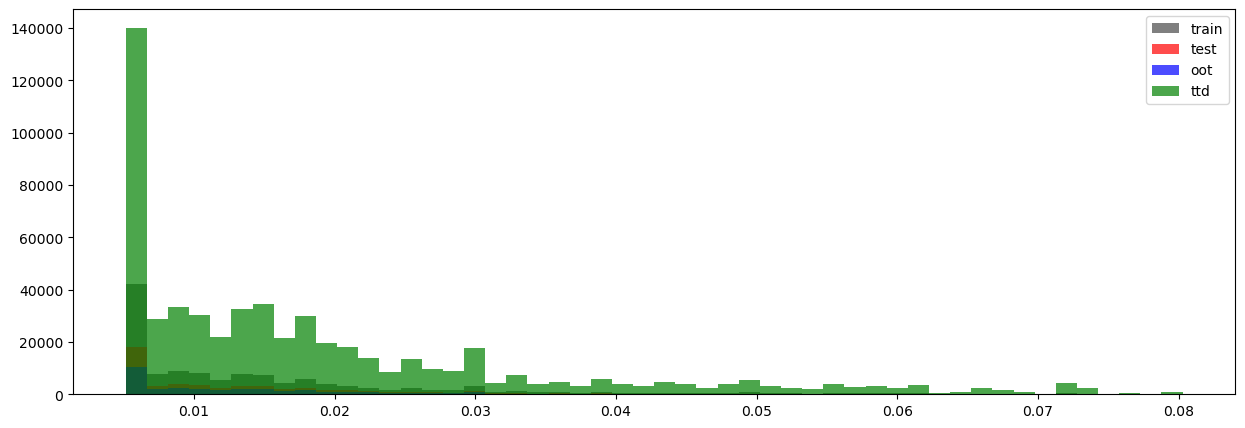

In [88]:
import matplotlib.pyplot as plt
plt.figure(figsize= (15, 5))
plt.hist(Train['p1'], bins= 50, label= 'train', color= 'black', alpha= 0.5)
plt.hist(Test['p1'], bins= 50, label= 'test', color= 'red', alpha= 0.7)
plt.hist(Oot['p1'], bins= 50, label= 'oot', color= 'blue', alpha= 0.7)
plt.hist(TTD['p1'], bins= 50, label= 'ttd', color= 'green', alpha= 0.7)
plt.legend()
plt.show()

In [89]:
Train['p1'].value_counts(dropna= False).head()

p1
0.005160    15842
0.005718     8543
0.005661     3802
0.005704     3397
0.010022     2529
Name: count, dtype: int64

In [90]:
df_bv= pd.DataFrame()

for col in col_list:
    print(col)
    ### Train
    temp_tr= Train.groupby(col).agg(
        bad_count_tr= ('bad_flag', 'sum'),
        bad_rate_tr= ('bad_flag', 'mean'),
                                p1_bad_rate_tr= ('p1', 'mean'),
                                   volume_tr= ('unique_id', 'count')).reset_index()
    temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_P1', 'Train_Count']
    temp_tr.insert(0, 'variable', col)
    
    # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
    # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
    # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
    # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
    ### Test
    temp_te= Test.groupby(col).agg(
        bad_count_te= ('bad_flag', 'sum'),
        bad_rate_te= ('bad_flag', 'mean'),
                                p1_bad_rate_te= ('p1', 'mean'),
                                  volume_te= ('unique_id', 'count')).reset_index()
    temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_P1', 'Test_Count']
    #temp_te['variable']= col
    
    # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
    # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
    # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
    # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
    ### Concatenating
    temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
    # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
    temp= Bucket_Order(temp)
    # display(temp)
    
    df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
    del temp, temp_tr, temp_te

assetownership
inquiryauto12month
sourcenonderogcount12month
inquiryshortterm12month
inquirytelcom12month
addrcurrenttaxmarketvalue
assetpropevercount
sourcenonderogcount
addrinputtaxmarketvalue
inquirynonshortterm12month
educationattendance
addrprevioustimeoldest
addrchangecount60month
addrinputtimenewest
addrlastmovetaxratiodiff
educationprogramattended
addrcurrentblockratio
addrinputdeedmailing
businessassociation
addrcurrenttimeoldest
assetpropcurrenttaxtotal
addrchangecount06month
educationinstitutionprivate
assetpropnewestmortgagetype
assetpropsalepurchaseratio
assetproppurchasetimeoldest
inquirycollections12month
subjectrecordtimenewest
addrinputproblems
addrchangecount03month
assetpropcurrentcount
addrcurrenttaxvalue
addronfilecount
addrinputtimelastsale
addrpreviouslengthofres
addrchangecount24month
addrinputphoneservice
addrcurrenttimenewest
inquirybanking12month
addrinputsubjectowned
addrcurrentavmratio12monthprior
assetpersonalcount
addrinputtaxvalue
addrchangecount12month


In [91]:
df_bv

,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,assetownership,[0],1277.0,0.027111,0.027251,47102,561.0,0.027603,0.027148,20324.0,Yes
1,assetownership,[1],507.0,0.006044,0.008781,83881,201.0,0.005613,0.008777,35812.0,Yes
2,inquiryauto12month,[0],1241.0,0.010566,0.013148,117457,509.0,0.010092,0.013187,50436.0,Yes
3,inquiryauto12month,[1],543.0,0.040145,0.035176,13526,253.0,0.044386,0.035256,5700.0,Yes
4,sourcenonderogcount12month,"[-inf, 2.0)",1363.0,0.021332,0.020056,63894,596.0,0.021759,0.020054,27391.0,Yes
5,sourcenonderogcount12month,"[2.0, inf)",421.0,0.006275,0.011010,67089,166.0,0.005775,0.011020,28745.0,Yes
6,inquiryshortterm12month,[0],1640.0,0.012734,0.015168,128794,693.0,0.012559,0.015173,55180.0,Yes
7,inquiryshortterm12month,[1],144.0,0.065783,0.030429,2189,69.0,0.072176,0.030172,956.0,Yes
8,inquirytelcom12month,[0],1677.0,0.013001,0.015163,128990,704.0,0.012733,0.015171,55289.0,Yes
9,inquirytelcom12month,[1],107.0,0.053688,0.032232,1993,58.0,0.068477,0.032213,847.0,Yes


In [92]:
for client in Train['client'].unique():
    print(client)
    get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
                  data= Train[Train['client']== client], 
                  data_h2o= train_h2o[train_h2o['client']== client], 
                  target= 'bad_flag', 
                  cols_tuple= col_tuple_pass, 
                  score_col= 'p1', 
                  weight= 'conwt')
    

Arkansas
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
25123 149.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.018647,0.080271,0.033040,5025,4932.0,93.0,1.85,20.0,19.75,62.42,42.67
1,0.012102,0.018647,0.014836,5025,5002.0,23.0,0.46,40.0,39.78,77.85,38.07
2,0.008294,0.012102,0.010134,5024,5008.0,16.0,0.32,60.0,59.83,88.59,28.76
3,0.005718,0.008294,0.006594,5025,5016.0,9.0,0.18,80.0,79.92,94.63,14.71
4,0.005160,0.005718,0.005337,5024,5016.0,8.0,0.16,100.0,100.00,100.00,0.00


{'Gini': 49.69, 'KS': 42.67}
Numerica
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
15059 217.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.021102,0.080271,0.032875,3012,2908.0,104.0,3.45,20.00,19.59,47.93,28.34
1,0.013740,0.021102,0.016973,3012,2952.0,60.0,1.99,40.00,39.48,75.58,36.10
2,0.008182,0.013724,0.010619,3012,2984.0,28.0,0.93,60.00,59.59,88.48,28.89
3,0.005718,0.008182,0.006616,3012,3000.0,12.0,0.40,80.01,79.80,94.01,14.21
4,0.005160,0.005718,0.005460,3011,2998.0,13.0,0.43,100.00,100.00,100.00,0.00


{'Gini': 43.02, 'KS': 36.1}
Tower
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
28501 487.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.019405,0.080271,0.033449,5701,5461.0,240.0,4.21,20.0,19.49,49.28,29.79
1,0.012448,0.019405,0.015402,5700,5570.0,130.0,2.28,40.0,39.38,75.98,36.60
2,0.007266,0.012448,0.009772,5700,5637.0,63.0,1.11,60.0,59.50,88.91,29.41
3,0.005704,0.007266,0.006034,5700,5664.0,36.0,0.63,80.0,79.72,96.30,16.58
4,0.005160,0.005704,0.005267,5700,5682.0,18.0,0.32,100.0,100.00,100.00,0.00


{'Gini': 44.95, 'KS': 36.6}
Bethpage
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
7729 45.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.019183,0.080271,0.032646,1546,1526.0,20.0,1.29,20.00,19.86,44.44,24.58
1,0.013393,0.019183,0.015755,1546,1536.0,10.0,0.65,40.01,39.85,66.67,26.82
2,0.007505,0.013393,0.010599,1546,1541.0,5.0,0.32,60.01,59.90,77.78,17.88
3,0.005661,0.007505,0.006137,1546,1540.0,6.0,0.39,80.01,79.95,91.11,11.16
4,0.005160,0.005661,0.005209,1545,1541.0,4.0,0.26,100.00,100.00,100.00,0.00


{'Gini': 32.18, 'KS': 26.82}
SECU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
11289 248.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.023400,0.080271,0.040386,2258,2117.0,141.0,6.24,20.00,19.17,56.85,37.68
1,0.014791,0.023339,0.018168,2258,2192.0,66.0,2.92,40.00,39.03,83.47,44.44
2,0.008026,0.014791,0.011695,2258,2237.0,21.0,0.93,60.01,59.29,91.94,32.65
3,0.005718,0.008026,0.006294,2258,2243.0,15.0,0.66,80.01,79.60,97.98,18.38
4,0.005160,0.005718,0.005373,2257,2252.0,5.0,0.22,100.00,100.00,100.00,0.00


{'Gini': 53.26, 'KS': 44.44}
CPM
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
6143 87.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.019237,0.080271,0.033254,1229,1185.0,44.0,3.58,20.01,19.57,50.57,31.00
1,0.012858,0.019234,0.015499,1229,1208.0,21.0,1.71,40.01,39.51,74.71,35.20
2,0.007969,0.012858,0.010260,1228,1220.0,8.0,0.65,60.00,59.66,83.91,24.25
3,0.005718,0.007969,0.006358,1229,1220.0,9.0,0.73,80.01,79.81,94.25,14.44
4,0.005160,0.005718,0.005359,1228,1223.0,5.0,0.41,100.00,100.00,100.00,0.00


{'Gini': 41.959999999999994, 'KS': 35.2}
GESA
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
17211 307.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.025382,0.080271,0.040239,3443,3289.0,154.0,4.47,20.0,19.46,50.16,30.70
1,0.016494,0.025382,0.020458,3442,3363.0,79.0,2.30,40.0,39.35,75.90,36.55
2,0.009739,0.016494,0.013570,3442,3392.0,50.0,1.45,60.0,59.42,92.18,32.76
3,0.005718,0.009739,0.007491,3442,3420.0,22.0,0.64,80.0,79.65,99.35,19.70
4,0.005160,0.005718,0.005438,3442,3440.0,2.0,0.06,100.0,100.00,100.00,0.00


{'Gini': 47.88, 'KS': 36.55}
Guardian
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
16232 204.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.029357,0.080271,0.045799,3247,3137.0,110.0,3.39,20.0,19.57,53.92,34.35
1,0.017362,0.029357,0.021534,3246,3198.0,48.0,1.48,40.0,39.52,77.45,37.93
2,0.011072,0.017362,0.013947,3247,3225.0,22.0,0.68,60.0,59.65,88.24,28.59
3,0.006272,0.011072,0.008471,3246,3236.0,10.0,0.31,80.0,79.84,93.14,13.30
4,0.005160,0.006272,0.005608,3246,3232.0,14.0,0.43,100.0,100.00,100.00,0.00


{'Gini': 45.67, 'KS': 37.93}
HFCU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
1742 29.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.020325,0.073663,0.034903,349,335.0,14.0,4.01,20.03,19.56,48.28,28.72
1,0.013439,0.020325,0.016332,348,342.0,6.0,1.72,40.01,39.52,68.97,29.45
2,0.008026,0.013393,0.010824,349,345.0,4.0,1.15,60.05,59.66,82.76,23.10
3,0.005661,0.008026,0.006371,348,347.0,1.0,0.29,80.02,79.92,86.21,6.29
4,0.005160,0.005661,0.005269,348,344.0,4.0,1.15,100.00,100.00,100.00,0.00


{'Gini': 35.03, 'KS': 29.45}
Hawaii
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
1419 4.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.025995,0.071336,0.038160,284,282.0,2.0,0.70,20.01,19.93,50.0,30.07
1,0.017378,0.025995,0.021046,284,284.0,0.0,0.00,40.03,40.00,50.0,10.00
2,0.014644,0.017378,0.016362,284,283.0,1.0,0.35,60.04,60.00,75.0,15.00
3,0.008488,0.014644,0.011541,284,284.0,0.0,0.00,80.06,80.07,75.0,5.07
4,0.005160,0.008365,0.006612,283,282.0,1.0,0.35,100.00,100.00,100.0,0.00


{'Gini': 20.02, 'KS': 30.07}
NCU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
535 7.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022689,0.073663,0.039129,108,105.0,3.0,2.78,20.19,19.89,42.86,22.97
1,0.015105,0.022413,0.017863,106,104.0,2.0,1.89,40.00,39.58,71.43,31.85
2,0.009725,0.015069,0.012874,108,107.0,1.0,0.93,60.19,59.85,85.71,25.86
3,0.005718,0.009643,0.007534,107,106.0,1.0,0.93,80.19,79.92,100.00,20.08
4,0.005160,0.005718,0.005340,106,106.0,0.0,0.00,100.00,100.00,100.00,0.00


{'Gini': 40.31, 'KS': 31.85}


### Basic Checks

In [173]:
TTD['funded_flag'].sum(), Train['funded_flag'].sum(), Test['funded_flag'].sum()

(21741.0, 15871.0, 6803.0)

In [93]:
TTD['id']= TTD['unique_id']+TTD['client']
Train['id']= Train['unique_id']+Train['client']
Test['id']= Test['unique_id']+Test['client']
Oot['id']= Oot['unique_id']+Oot['client']

In [94]:
TTD[TTD['id'].isin(Train[Train['client']!= 'CPM']['id'].unique())]['p1'].describe(), Train[Train['client']!= 'CPM']['p1'].describe()

(count    124840.000000
 mean          0.015485
 std           0.013134
 min           0.005160
 25%           0.006048
 50%           0.011072
 75%           0.019183
 max           0.080271
 Name: p1, dtype: float64,
 count    124840.000000
 mean          0.015485
 std           0.013134
 min           0.005160
 25%           0.006048
 50%           0.011072
 75%           0.019183
 max           0.080271
 Name: p1, dtype: float64)

In [95]:
import datetime

In [96]:
# Train[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Train_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
# Test[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Test_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
# Oot[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Oot_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
# TTD[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_TTD_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)

In [97]:
Train['fico_pb'].describe()

count    130811.000000
mean        722.417411
std         130.141791
min           0.000000
25%         686.000000
50%         740.000000
75%         793.000000
max         900.000000
Name: fico_pb, dtype: float64

In [98]:
TTD['fico_cut']= np.where(((TTD['fico_pb'].isnull()) |(TTD['fico_pb']<300)),"h.Missing",
                        np.where((TTD['fico_pb']>=300) &(TTD['fico_pb']<550),"a.300-550",
                                 np.where((TTD['fico_pb']>=550) &(TTD['fico_pb']<600),"a.550-600",
                                np.where((TTD['fico_pb']>=600) &(TTD['fico_pb']<630),"b.600-629",
                                    np.where((TTD['fico_pb']>=630) &(TTD['fico_pb']<660),"c.630-659",
                                        np.where((TTD['fico_pb']>=660) &(TTD['fico_pb']<690),"d.660-689",
                                            np.where((TTD['fico_pb']>=690) &(TTD['fico_pb']<715),"e.690-714",
                                                np.where((TTD['fico_pb']>=715) & (TTD['fico_pb']<740),"f.715-739",
                                                    np.where((TTD['fico_pb']>=740),"g.740+","h.Missing")))))))))

In [99]:
TTD.groupby('fico_cut').agg(
    ttd= ('unique_id', 'count'),
    approved= ('approve_flag', 'sum'),
    funded= ('funded_flag', 'sum'),
    bad= ('bad_flag', 'sum'),
    avg_pd= ('p1', 'mean')
)

,ttd,approved,funded,bad,avg_pd
fico_cut,,,,,
a.300-550,22990,1941.0,1236.0,81.0,0.032609
a.550-600,36446,9459.0,3717.0,242.0,0.029270
b.600-629,41805,17657.0,5800.0,280.0,0.026295
c.630-659,60023,30298.0,11594.0,407.0,0.023206
d.660-689,73057,43045.0,19974.0,424.0,0.020216
e.690-714,62994,41787.0,20457.0,267.0,0.017805
f.715-739,57545,41375.0,21052.0,167.0,0.016382
g.740+,192612,162513.0,90281.0,227.0,0.011956
h.Missing,30730,8131.0,4296.0,334.0,0.026992


In [100]:
TTD.shape

(578202, 148)